image
* size : 128X128
* channel : 3 channel, just copy

augment
* heng's augment + cutmix, mixup, cutout

cnn tail design
* https://www.kaggle.com/c/bengaliai-cv19/discussion/123432

In [1]:
import warnings
warnings.filterwarnings("ignore")

import gc
import os
from pathlib import Path
import random
import sys
import math
import timedata_loader
import multiprocessing

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader
import apex
from apex import amp
from apex.parallel import DistributedDataParallel

import albumentations as A
import cv2
from PIL import Image, ImageEnhance, ImageOps

%matplotlib inline

pd.options.display.max_rows = 10000
#pd.options.display.max_columns = None
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 100

In [2]:
for i in tqdm(range(1), total=1):
    print(i)

0



In [3]:
from torchvision import transforms
import pretrainedmodels

In [4]:
debug=False
submission=False
batch_size=64*torch.cuda.device_count()


#device='cuda:0'
device='cuda'
out='.'
image_size=128
image_height=137
image_width=236
arch='pretrained'
model_name='se_resnext50_32x4d'
#model_name='resnet34'
num_epochs = 150
experi_num = '0039'
val_fold = 0
num_workers=multiprocessing.cpu_count()//2

SEED = 42

print(f'batch_size:{batch_size}, num_workers:{num_workers}')

batch_size:512, num_workers:32


In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [6]:
datadir = Path('../input')
featherdir = Path('../input')
logdir = Path('../log')
modeldir = Path('../model')

In [7]:
def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}_{image_size}_{image_size}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    images = [df.iloc[:, 1:].values.reshape(-1, image_size, image_size) for df in image_df_list]
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images

In [8]:
def clear_cache():
    gc.collect()
    torch.cuda.empty_cache()

In [9]:
train = pd.read_csv(datadir/'train_with_fold2.csv')
le = preprocessing.LabelEncoder()
train['grapheme_enc'] = le.fit_transform(train['grapheme'])
train.head(10)

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,fold,grapheme_enc
0,Train_0,15,9,5,ক্ট্রো,4,44
1,Train_1,159,0,0,হ,2,1248
2,Train_2,22,3,5,খ্রী,4,103
3,Train_3,53,2,2,র্টি,2,888
4,Train_4,71,9,5,থ্রো,1,438
5,Train_5,153,9,0,স্পো,2,1215
6,Train_6,52,2,0,ঞ্জি,2,282
7,Train_7,139,3,0,ষী,2,1100
8,Train_8,67,0,0,ত্থ,4,394
9,Train_9,64,7,1,তেঁ,3,378


In [10]:
grapheme_map = train[['grapheme_root','vowel_diacritic','consonant_diacritic','grapheme_enc']].drop_duplicates()
grapheme_map = grapheme_map.set_index('grapheme_enc')
print(grapheme_map.shape)
grapheme_map.head(10)

(1295, 3)


,grapheme_root,vowel_diacritic,consonant_diacritic
grapheme_enc,,,
44,15,9,5
1248,159,0,0
103,22,3,5
888,53,2,2
438,71,9,5
1215,153,9,0
282,52,2,0
1100,139,3,0
394,67,0,0


In [11]:
gr_map = grapheme_map.reset_index()[['grapheme_enc','grapheme_root']].to_dict(orient='records')
gr_map = {r['grapheme_enc']:r['grapheme_root'] for r in gr_map}

v_map = grapheme_map.reset_index()[['grapheme_enc','vowel_diacritic']].to_dict(orient='records')
v_map = {r['grapheme_enc']:r['vowel_diacritic'] for r in v_map}

c_map = grapheme_map.reset_index()[['grapheme_enc','consonant_diacritic']].to_dict(orient='records')
c_map = {r['grapheme_enc']:r['consonant_diacritic'] for r in c_map}

In [12]:
%%time

train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic','grapheme_enc']].values
indices = [0] if debug else [0, 1, 2, 3]
train_images = prepare_image(datadir, featherdir, data_type='train', submission=False, indices=indices)
print(train_images.shape)

image_df_list 4
(200840, 128, 128)
CPU times: user 4.89 s, sys: 21.5 s, total: 26.3 s
Wall time: 5.78 s


In [13]:
class BengaliAIDataset(Dataset):

    def __init__(self, images, labels=None, transform=None, indices=None):
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        i = self.indices[i]
        image = self.images[i]
        #image = np.stack((image, image, image), axis=-1)
        #image = cv2.cvtColor(image ,cv2.COLOR_GRAY2RGB)
        #image = image.reshape(image_size, image_size, -1)
        image = 1-(image/255.0).astype(np.float32)
        
        #if self.transform:
        #    image = self.transform(image=image)['image']
        #image = np.transpose(image, (2, 0, 1)).astype(np.float32)

        y = self.labels[i]
        if self.transform:
            aug_image = self.transform(image)
            image = image.reshape(image_size, image_size, -1)
            image = np.transpose(image, (2, 0, 1)).astype(np.float32)
            aug_image = aug_image.reshape(image_size, image_size, -1)
            aug_image = np.transpose(aug_image, (2, 0, 1)).astype(np.float32)
            return image, aug_image, y[0], y[1], y[2], y[3]
        else:
            image = image.reshape(image_size, image_size, -1)
            image = np.transpose(image, (2, 0, 1)).astype(np.float32)
            return image, y[0], y[1], y[2], y[3]

In [14]:
train_dataset = BengaliAIDataset(train_images, train_labels)
image, gr, v, c, g = train_dataset[0]
print(f'image.shape: {image.shape}, label:{gr},{v},{c},{g}')
image

image.shape: (1, 128, 128), label:15,9,5,44


array([[[0.00784314, 0.01176471, 0.01568627, ..., 0.00784314,
         0.00392157, 0.01176471],
        [0.00392157, 0.00784314, 0.01176471, ..., 0.00392157,
         0.00392157, 0.01176471],
        [0.        , 0.        , 0.00392157, ..., 0.        ,
         0.00392157, 0.00784314],
        ...,
        [0.00392157, 0.00784314, 0.00784314, ..., 0.00784314,
         0.00784314, 0.00784314],
        [0.00392157, 0.00392157, 0.00392157, ..., 0.00784314,
         0.00784314, 0.01176471],
        [0.00392157, 0.00392157, 0.00392157, ..., 0.00784314,
         0.00784314, 0.01176471]]], dtype=float32)

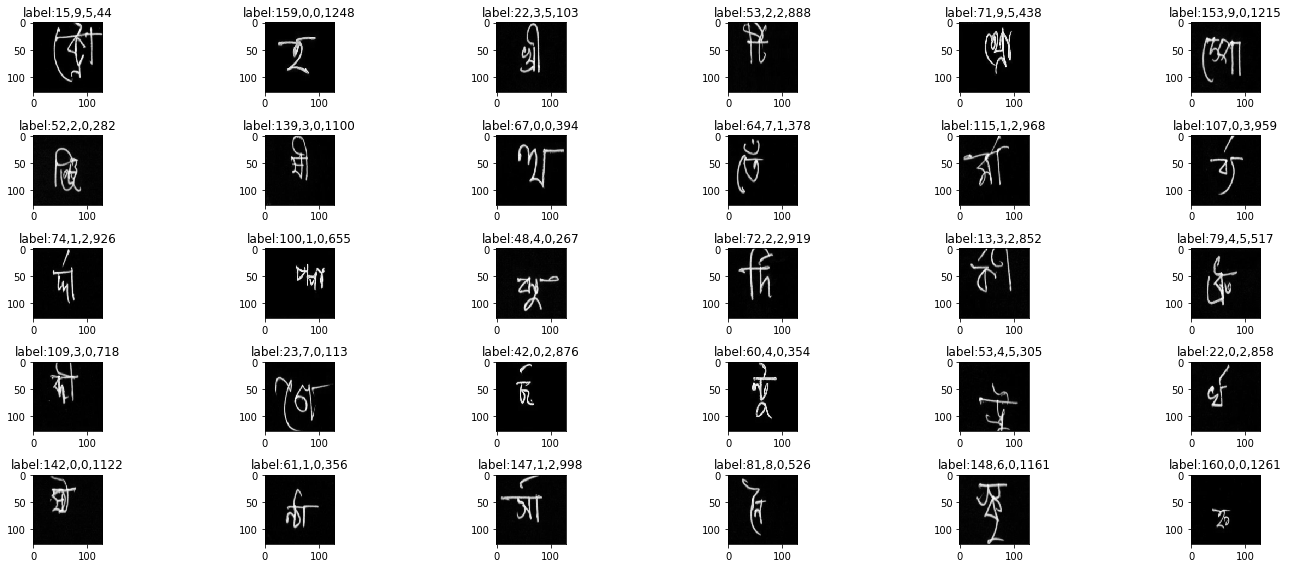

In [15]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, gr, v, c, g = train_dataset[i]
    ax.imshow(image.reshape(image_size, image_size), cmap='gray')
    ax.set_title(f'label:{gr},{v},{c},{g}')
plt.tight_layout()
plt.show()

In [16]:
# helper --
def make_grid_image(width,height, grid_size=16):

    image = np.zeros((height,width),np.float32)
    for y in range(0,height,2*grid_size):
        for x in range(0,width,2*grid_size):
             image[y: y+grid_size,x:x+grid_size] = 1

    # for y in range(height+grid_size,2*grid_size):
    #     for x in range(width+grid_size,2*grid_size):
    #          image[y: y+grid_size,x:x+grid_size] = 1

    return image

#---

def do_identity(image, magnitude=None):
    return image


# *** geometric ***

def do_random_projective(image, magnitude=0.5):
    mag = np.random.uniform(-1, 1) * 0.5*magnitude

    height, width = image.shape[:2]
    x0,y0=0,0
    x1,y1=1,0
    x2,y2=1,1
    x3,y3=0,1

    mode = np.random.choice(['top','bottom','left','right'])
    if mode =='top':
        x0 += mag;   x1 -= mag
    if mode =='bottom':
        x3 += mag;   x2 -= mag
    if mode =='left':
        y0 += mag;   y3 -= mag
    if mode =='right':
        y1 += mag;   y2 -= mag

    s = np.array([[ 0, 0],[ 1, 0],[ 1, 1],[ 0, 1],])*[[width, height]]
    d = np.array([[x0,y0],[x1,y1],[x2,y2],[x3,y3],])*[[width, height]]
    transform = cv2.getPerspectiveTransform(s.astype(np.float32),d.astype(np.float32))

    image = cv2.warpPerspective( image, transform, (width, height), flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_CONSTANT, borderValue=0)

    return image


def do_random_perspective(image, magnitude=0.5):
    mag = np.random.uniform(-1, 1, (4,2)) * 0.25*magnitude

    height, width = image.shape[:2]
    s = np.array([[ 0, 0],[ 1, 0],[ 1, 1],[ 0, 1],])
    d = s+mag
    s *= [[width, height]]
    d *= [[width, height]]
    transform = cv2.getPerspectiveTransform(s.astype(np.float32),d.astype(np.float32))

    image = cv2.warpPerspective( image, transform, (width, height), flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_CONSTANT, borderValue=0)

    return image


def do_random_scale( image, magnitude=0.5 ):
    s = 1+np.random.uniform(-1, 1)*magnitude*0.5

    height, width = image.shape[:2]
    transform = np.array([
        [s,0,0],
        [0,s,0],
    ],np.float32)
    image = cv2.warpAffine( image, transform, (width, height), flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return image



def do_random_shear_x( image, magnitude=0.5 ):
    sx = np.random.uniform(-1, 1)*magnitude

    height, width = image.shape[:2]
    transform = np.array([
        [1,sx,0],
        [0,1,0],
    ],np.float32)
    image = cv2.warpAffine( image, transform, (width, height), flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return image


def do_random_shear_y( image, magnitude=0.5 ):
    sy = np.random.uniform(-1, 1)*magnitude

    height, width = image.shape[:2]
    transform = np.array([
        [1, 0,0],
        [sy,1,0],
    ],np.float32)
    image = cv2.warpAffine( image, transform, (width, height), flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return image


def do_random_stretch_x(image, magnitude=0.5 ):
    sx = 1+np.random.uniform(-1, 1)*magnitude

    height, width = image.shape[:2]
    transform = np.array([
        [sx,0,0],
        [0, 1,0],
    ],np.float32)
    image = cv2.warpAffine( image, transform, (width, height), flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return image


def do_random_stretch_y(image, magnitude=0.5 ):
    sy = 1+np.random.uniform(-1, 1)*magnitude

    height, width = image.shape[:2]
    transform = np.array([
        [1, 0,0],
        [0,sy,0],
    ],np.float32)
    image = cv2.warpAffine( image, transform, (width, height), flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return image


def do_random_rotate(image, magnitude=0.5 ):
    angle = 1+np.random.uniform(-1, 1)*30*magnitude

    height, width = image.shape[:2]
    cx, cy = width // 2, height // 2

    transform = cv2.getRotationMatrix2D((cx, cy), -angle, 1.0)
    image = cv2.warpAffine( image, transform, (width, height), flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return image


#----
def do_random_grid_distortion(image, magnitude=0.5 ):
    num_step = 5
    distort  = magnitude

    # http://pythology.blogspot.sg/2014/03/interpolation-on-regular-distorted-grid.html
    distort_x = [1 + random.uniform(-distort,distort) for i in range(num_step + 1)]
    distort_y = [1 + random.uniform(-distort,distort) for i in range(num_step + 1)]

    #---
    height, width = image.shape[:2]
    xx = np.zeros(width, np.float32)
    step_x = width // num_step

    prev = 0
    for i, x in enumerate(range(0, width, step_x)):
        start = x
        end   = x + step_x
        if end > width:
            end = width
            cur = width
        else:
            cur = prev + step_x * distort_x[i]

        xx[start:end] = np.linspace(prev, cur, end - start)
        prev = cur

    yy = np.zeros(height, np.float32)
    step_y = height // num_step
    prev = 0
    for idx, y in enumerate(range(0, height, step_y)):
        start = y
        end = y + step_y
        if end > height:
            end = height
            cur = height
        else:
            cur = prev + step_y * distort_y[idx]

        yy[start:end] = np.linspace(prev, cur, end - start)
        prev = cur

    map_x, map_y = np.meshgrid(xx, yy)
    map_x = map_x.astype(np.float32)
    map_y = map_y.astype(np.float32)
    image = cv2.remap(image, map_x, map_y, interpolation=cv2.INTER_LINEAR,
                      borderMode=cv2.BORDER_CONSTANT, borderValue=0)

    return image

#https://github.com/albumentations-team/albumentations/blob/8b58a3dbd2f35558b3790a1dbff6b42b98e89ea5/albumentations/augmentations/transforms.py

# https://ciechanow.ski/mesh-transforms/
# https://stackoverflow.com/questions/53907633/how-to-warp-an-image-using-deformed-mesh
# http://pythology.blogspot.sg/2014/03/interpolation-on-regular-distorted-grid.html
def do_random_custom_distortion1(image, magnitude=0.5):
    distort=magnitude*0.3

    height,width = image.shape
    s_x = np.array([0.0, 0.5, 1.0,  0.0, 0.5, 1.0,  0.0, 0.5, 1.0])
    s_y = np.array([0.0, 0.0, 0.0,  0.5, 0.5, 0.5,  1.0, 1.0, 1.0])
    d_x = s_x.copy()
    d_y = s_y.copy()
    d_x[[1,4,7]] += np.random.uniform(-distort,distort, 3)
    d_y[[3,4,5]] += np.random.uniform(-distort,distort, 3)

    s_x = (s_x*width )
    s_y = (s_y*height)
    d_x = (d_x*width )
    d_y = (d_y*height)

    #---
    distort = np.zeros((height,width),np.float32)
    for index in ([4,1,3],[4,1,5],[4,7,3],[4,7,5]):
        point = np.stack([s_x[index],s_y[index]]).T
        qoint = np.stack([d_x[index],d_y[index]]).T

        src  = np.array(point, np.float32)
        dst  = np.array(qoint, np.float32)
        mat  = cv2.getAffineTransform(src, dst)

        point = np.round(point).astype(np.int32)
        x0 = np.min(point[:,0])
        x1 = np.max(point[:,0])
        y0 = np.min(point[:,1])
        y1 = np.max(point[:,1])
        mask = np.zeros((height,width),np.float32)
        mask[y0:y1,x0:x1] = 1

        mask = mask*image
        warp = cv2.warpAffine(mask, mat, (width, height),borderMode=cv2.BORDER_REPLICATE)
        distort = np.maximum(distort,warp)
        #distort = distort+warp

    return distort


# *** intensity ***
def do_random_contrast(image, magnitude=0.5):
    alpha = 1 + random.uniform(-1,1)*magnitude
    image = image.astype(np.float32) * alpha
    image = np.clip(image,0,1)
    return image


def do_random_block_fade(image, magnitude=0.5):
    size  = [0.1, magnitude]

    height,width = image.shape

    #get bounding box
    m = image.copy()
    cv2.rectangle(m,(0,0),(height,width),1,5)
    m = image<0.5
    if m.sum()==0: return image

    m = np.where(m)
    y0,y1,x0,x1 = np.min(m[0]), np.max(m[0]), np.min(m[1]), np.max(m[1])
    w = x1-x0
    h = y1-y0
    if w*h<10: return image

    ew, eh = np.random.uniform(*size,2)
    ew = int(ew*w)
    eh = int(eh*h)

    ex = np.random.randint(0,w-ew)+x0
    ey = np.random.randint(0,h-eh)+y0

    image[ey:ey+eh, ex:ex+ew] *= np.random.uniform(0.1,0.5) #1 #
    image = np.clip(image,0,1)
    return image


# *** noise ***
# https://www.kaggle.com/ren4yu/bengali-morphological-ops-as-image-augmentation
def do_random_erode(image, magnitude=0.5):
    s = int(round(1 + np.random.uniform(0,1)*magnitude*6))
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, tuple((s,s)))
    image  = cv2.erode(image, kernel, iterations=1)
    return image

def do_random_dilate(image, magnitude=0.5):
    s = int(round(1 + np.random.uniform(0,1)*magnitude*6))
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, tuple((s,s)))
    image  = cv2.dilate(image, kernel, iterations=1)
    return image

def do_random_sprinkle(image, magnitude=0.5):

    size = 16
    num_sprinkle = int(round( 1 + np.random.randint(10)*magnitude ))

    height,width = image.shape
    image = image.copy()
    image_small = cv2.resize(image, dsize=None, fx=0.25, fy=0.25)
    m   = np.where(image_small>0.25)
    num = len(m[0])
    if num==0: return image

    s = size//2
    i = np.random.choice(num, num_sprinkle)
    for y,x in zip(m[0][i],m[1][i]):
        y=y*4+2
        x=x*4+2
        image[y-s:y+s, x-s:x+s] = 0 #0.5 #1 #
    return image


#https://stackoverflow.com/questions/14435632/impulse-gaussian-and-salt-and-pepper-noise-with-opencv
def do_random_noise(image, magnitude=0.5):
    height,width = image.shape
    noise = np.random.uniform(-1,1,(height,width))*magnitude*0.7
    image = image+noise
    image = np.clip(image,0,1)
    return image



def do_random_line(image, magnitude=0.5):
    num_lines = int(round(1 + np.random.randint(8)*magnitude))

    # ---
    height,width = image.shape
    image = image.copy()

    def line0():
        return (0,0),(width-1,0)

    def line1():
        return (0,height-1),(width-1,height-1)

    def line2():
        return (0,0),(0,height-1)

    def line3():
        return (width-1,0),(width-1,height-1)

    def line4():
        x0,x1 = np.random.choice(width,2)
        return (x0,0),(x1,height-1)

    def line5():
        y0,y1 = np.random.choice(height,2)
        return (0,y0),(width-1,y1)

    for i in range(num_lines):
        p = np.array([1/4,1/4,1/4,1/4,1,1])
        func = np.random.choice([line0,line1,line2,line3,line4,line5],p=p/p.sum())
        (x0,y0),(x1,y1) = func()

        color     = np.random.uniform(0,1)
        thickness = np.random.randint(1,5)
        line_type = np.random.choice([cv2.LINE_AA,cv2.LINE_4,cv2.LINE_8])

        cv2.line(image,(x0,y0),(x1,y1), color, thickness, line_type)

    return image



# batch augmentation that uses pairing, e.g mixup, cutmix, cutout #####################
def make_object_box(image):
    m = image.copy()
    cv2.rectangle(m,(0,0),(236, 137), 0, 10)
    m = m-np.min(m)
    m = m/np.max(m)
    h = m<0.5

    row = np.any(h, axis=1)
    col = np.any(h, axis=0)
    y0, y1 = np.where(row)[0][[0, -1]]
    x0, x1 = np.where(col)[0][[0, -1]]

    return [x0,y0],[x1,y1]




def do_random_batch_mixup(input, onehot):
    batch_size = len(input)

    alpha = 0.4 #0.2  #0.2,0.4
    gamma = np.random.beta(alpha, alpha, batch_size)
    gamma = np.maximum(1-gamma,gamma)

    # #mixup https://github.com/moskomule/mixup.pytorch/blob/master/main.py
    gamma = torch.from_numpy(gamma).float().to(input.device)
    perm  = torch.randperm(batch_size).to(input.device)
    perm_input  = input[perm]
    perm_onehot = [t[perm] for t in onehot]

    gamma = gamma.view(batch_size,1,1,1)
    mix_input  = gamma*input + (1-gamma)*perm_input
    gamma = gamma.view(batch_size,1)
    mix_onehot = [gamma*t + (1-gamma)*perm_t for t,perm_t in zip(onehot,perm_onehot)]

    return mix_input, mix_onehot, (perm_input, perm_onehot)


def do_random_batch_cutout(input, onehot):
    batch_size,C,H,W = input.shape

    mask = np.ones((batch_size,C,H,W ), np.float32)
    for b in range(batch_size):

        length = int(np.random.uniform(0.1,0.5)*min(H,W))
        y = np.random.randint(H)
        x = np.random.randint(W)

        y0 = np.clip(y - length // 2, 0, H)
        y1 = np.clip(y + length // 2, 0, H)
        x0 = np.clip(x - length // 2, 0, W)
        x1 = np.clip(x + length // 2, 0, W)
        mask[b, :, y0: y1, x0: x1] = 0
    mask  = torch.from_numpy(mask).to(input.device)

    input = input*mask
    return input, onehot, None

In [17]:
def valid_augment(image):
    return image


def train_augment(image):
    if 1:
        for op in np.random.choice([
            lambda image : do_identity(image),
            lambda image : do_random_projective(image, 0.4),
            lambda image : do_random_perspective(image, 0.4),
            lambda image : do_random_scale(image, 0.4),
            lambda image : do_random_rotate(image, 0.4),
            lambda image : do_random_shear_x(image, 0.5),
            lambda image : do_random_shear_y(image, 0.4),
            lambda image : do_random_stretch_x(image, 0.5),
            lambda image : do_random_stretch_y(image, 0.5),
            lambda image : do_random_grid_distortion(image, 0.4),
            lambda image : do_random_custom_distortion1(image, 0.5),
        ],1):
            image = op(image)

        for op in np.random.choice([
            lambda image : do_identity(image),
            lambda image : do_random_erode(image, 0.4),
            lambda image : do_random_dilate(image, 0.4),
            lambda image : do_random_sprinkle(image, 0.5),
            lambda image : do_random_line(image, 0.5),
        ],1):
            image = op(image)

        for op in np.random.choice([
            lambda image : do_identity(image),
            lambda image : do_random_contrast(image, 0.5),
            lambda image : do_random_block_fade(image, 0.5),
        ],1):
            image = op(image)

        #image = do_random_pad_crop(image, 3)
    return image

In [18]:
train_dataset = BengaliAIDataset(train_images, train_labels, transform=train_augment)

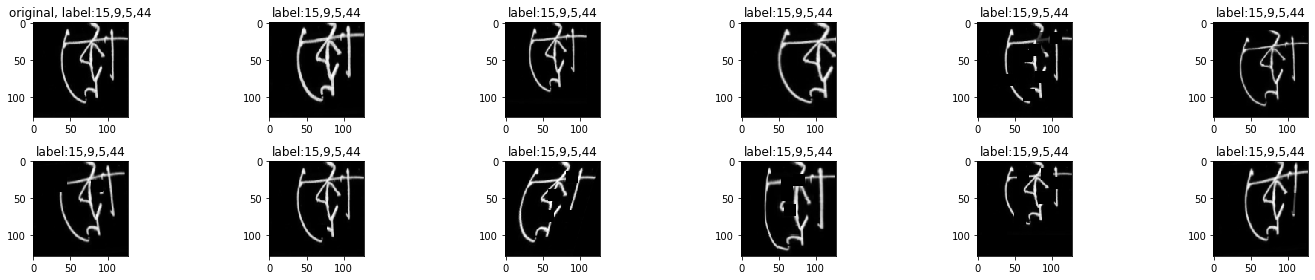

In [19]:
nrow, ncol = 2, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 4))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, aug_image, gr, v, c, g = train_dataset[0]
    if i == 0:
        ax.imshow(image.reshape(image_size,image_size), cmap='gray')
        ax.set_title(f'original, label:{gr},{v},{c},{g}')
    else:
        ax.imshow(aug_image.reshape(image_size,image_size), cmap='gray')
        ax.set_title(f'label:{gr},{v},{c},{g}')
plt.tight_layout()
plt.show()

In [20]:
def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps
    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)       
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'
    
class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x *( torch.tanh(F.softplus(x)))

In [21]:
IMAGE_RGB_MEAN = [0.485, 0.456, 0.406]
IMAGE_RGB_STD  = [0.229, 0.224, 0.225]
PRETRAIN_FILE = '../pretrained_model/se_resnext50_32x4d-a260b3a4.pth'
NUM_CLASS = [168,11,7,1295]

In [22]:
CONVERSION=[
 'block0.0.weight',	(64, 3, 7, 7),	 'layer0.conv1.weight',	(64, 3, 7, 7),
 'block0.1.weight',	(64,),	 'layer0.bn1.weight',	(64,),
 'block0.1.bias',	(64,),	 'layer0.bn1.bias',	(64,),
 'block0.1.running_mean',	(64,),	 'layer0.bn1.running_mean',	(64,),
 'block0.1.running_var',	(64,),	 'layer0.bn1.running_var',	(64,),
 'block1.0.conv_bn1.conv.weight',	(128, 64, 1, 1),	 'layer1.0.conv1.weight',	(128, 64, 1, 1),
 'block1.0.conv_bn1.bn.weight',	(128,),	 'layer1.0.bn1.weight',	(128,),
 'block1.0.conv_bn1.bn.bias',	(128,),	 'layer1.0.bn1.bias',	(128,),
 'block1.0.conv_bn1.bn.running_mean',	(128,),	 'layer1.0.bn1.running_mean',	(128,),
 'block1.0.conv_bn1.bn.running_var',	(128,),	 'layer1.0.bn1.running_var',	(128,),
 'block1.0.conv_bn2.conv.weight',	(128, 4, 3, 3),	 'layer1.0.conv2.weight',	(128, 4, 3, 3),
 'block1.0.conv_bn2.bn.weight',	(128,),	 'layer1.0.bn2.weight',	(128,),
 'block1.0.conv_bn2.bn.bias',	(128,),	 'layer1.0.bn2.bias',	(128,),
 'block1.0.conv_bn2.bn.running_mean',	(128,),	 'layer1.0.bn2.running_mean',	(128,),
 'block1.0.conv_bn2.bn.running_var',	(128,),	 'layer1.0.bn2.running_var',	(128,),
 'block1.0.conv_bn3.conv.weight',	(256, 128, 1, 1),	 'layer1.0.conv3.weight',	(256, 128, 1, 1),
 'block1.0.conv_bn3.bn.weight',	(256,),	 'layer1.0.bn3.weight',	(256,),
 'block1.0.conv_bn3.bn.bias',	(256,),	 'layer1.0.bn3.bias',	(256,),
 'block1.0.conv_bn3.bn.running_mean',	(256,),	 'layer1.0.bn3.running_mean',	(256,),
 'block1.0.conv_bn3.bn.running_var',	(256,),	 'layer1.0.bn3.running_var',	(256,),
 'block1.0.scale.fc1.weight',	(16, 256, 1, 1),	 'layer1.0.se_module.fc1.weight',	(16, 256, 1, 1),
 'block1.0.scale.fc1.bias',	(16,),	 'layer1.0.se_module.fc1.bias',	(16,),
 'block1.0.scale.fc2.weight',	(256, 16, 1, 1),	 'layer1.0.se_module.fc2.weight',	(256, 16, 1, 1),
 'block1.0.scale.fc2.bias',	(256,),	 'layer1.0.se_module.fc2.bias',	(256,),
 'block1.0.shortcut.conv.weight',	(256, 64, 1, 1),	 'layer1.0.downsample.0.weight',	(256, 64, 1, 1),
 'block1.0.shortcut.bn.weight',	(256,),	 'layer1.0.downsample.1.weight',	(256,),
 'block1.0.shortcut.bn.bias',	(256,),	 'layer1.0.downsample.1.bias',	(256,),
 'block1.0.shortcut.bn.running_mean',	(256,),	 'layer1.0.downsample.1.running_mean',	(256,),
 'block1.0.shortcut.bn.running_var',	(256,),	 'layer1.0.downsample.1.running_var',	(256,),
 'block1.1.conv_bn1.conv.weight',	(128, 256, 1, 1),	 'layer1.1.conv1.weight',	(128, 256, 1, 1),
 'block1.1.conv_bn1.bn.weight',	(128,),	 'layer1.1.bn1.weight',	(128,),
 'block1.1.conv_bn1.bn.bias',	(128,),	 'layer1.1.bn1.bias',	(128,),
 'block1.1.conv_bn1.bn.running_mean',	(128,),	 'layer1.1.bn1.running_mean',	(128,),
 'block1.1.conv_bn1.bn.running_var',	(128,),	 'layer1.1.bn1.running_var',	(128,),
 'block1.1.conv_bn2.conv.weight',	(128, 4, 3, 3),	 'layer1.1.conv2.weight',	(128, 4, 3, 3),
 'block1.1.conv_bn2.bn.weight',	(128,),	 'layer1.1.bn2.weight',	(128,),
 'block1.1.conv_bn2.bn.bias',	(128,),	 'layer1.1.bn2.bias',	(128,),
 'block1.1.conv_bn2.bn.running_mean',	(128,),	 'layer1.1.bn2.running_mean',	(128,),
 'block1.1.conv_bn2.bn.running_var',	(128,),	 'layer1.1.bn2.running_var',	(128,),
 'block1.1.conv_bn3.conv.weight',	(256, 128, 1, 1),	 'layer1.1.conv3.weight',	(256, 128, 1, 1),
 'block1.1.conv_bn3.bn.weight',	(256,),	 'layer1.1.bn3.weight',	(256,),
 'block1.1.conv_bn3.bn.bias',	(256,),	 'layer1.1.bn3.bias',	(256,),
 'block1.1.conv_bn3.bn.running_mean',	(256,),	 'layer1.1.bn3.running_mean',	(256,),
 'block1.1.conv_bn3.bn.running_var',	(256,),	 'layer1.1.bn3.running_var',	(256,),
 'block1.1.scale.fc1.weight',	(16, 256, 1, 1),	 'layer1.1.se_module.fc1.weight',	(16, 256, 1, 1),
 'block1.1.scale.fc1.bias',	(16,),	 'layer1.1.se_module.fc1.bias',	(16,),
 'block1.1.scale.fc2.weight',	(256, 16, 1, 1),	 'layer1.1.se_module.fc2.weight',	(256, 16, 1, 1),
 'block1.1.scale.fc2.bias',	(256,),	 'layer1.1.se_module.fc2.bias',	(256,),
 'block1.2.conv_bn1.conv.weight',	(128, 256, 1, 1),	 'layer1.2.conv1.weight',	(128, 256, 1, 1),
 'block1.2.conv_bn1.bn.weight',	(128,),	 'layer1.2.bn1.weight',	(128,),
 'block1.2.conv_bn1.bn.bias',	(128,),	 'layer1.2.bn1.bias',	(128,),
 'block1.2.conv_bn1.bn.running_mean',	(128,),	 'layer1.2.bn1.running_mean',	(128,),
 'block1.2.conv_bn1.bn.running_var',	(128,),	 'layer1.2.bn1.running_var',	(128,),
 'block1.2.conv_bn2.conv.weight',	(128, 4, 3, 3),	 'layer1.2.conv2.weight',	(128, 4, 3, 3),
 'block1.2.conv_bn2.bn.weight',	(128,),	 'layer1.2.bn2.weight',	(128,),
 'block1.2.conv_bn2.bn.bias',	(128,),	 'layer1.2.bn2.bias',	(128,),
 'block1.2.conv_bn2.bn.running_mean',	(128,),	 'layer1.2.bn2.running_mean',	(128,),
 'block1.2.conv_bn2.bn.running_var',	(128,),	 'layer1.2.bn2.running_var',	(128,),
 'block1.2.conv_bn3.conv.weight',	(256, 128, 1, 1),	 'layer1.2.conv3.weight',	(256, 128, 1, 1),
 'block1.2.conv_bn3.bn.weight',	(256,),	 'layer1.2.bn3.weight',	(256,),
 'block1.2.conv_bn3.bn.bias',	(256,),	 'layer1.2.bn3.bias',	(256,),
 'block1.2.conv_bn3.bn.running_mean',	(256,),	 'layer1.2.bn3.running_mean',	(256,),
 'block1.2.conv_bn3.bn.running_var',	(256,),	 'layer1.2.bn3.running_var',	(256,),
 'block1.2.scale.fc1.weight',	(16, 256, 1, 1),	 'layer1.2.se_module.fc1.weight',	(16, 256, 1, 1),
 'block1.2.scale.fc1.bias',	(16,),	 'layer1.2.se_module.fc1.bias',	(16,),
 'block1.2.scale.fc2.weight',	(256, 16, 1, 1),	 'layer1.2.se_module.fc2.weight',	(256, 16, 1, 1),
 'block1.2.scale.fc2.bias',	(256,),	 'layer1.2.se_module.fc2.bias',	(256,),
 'block2.0.conv_bn1.conv.weight',	(256, 256, 1, 1),	 'layer2.0.conv1.weight',	(256, 256, 1, 1),
 'block2.0.conv_bn1.bn.weight',	(256,),	 'layer2.0.bn1.weight',	(256,),
 'block2.0.conv_bn1.bn.bias',	(256,),	 'layer2.0.bn1.bias',	(256,),
 'block2.0.conv_bn1.bn.running_mean',	(256,),	 'layer2.0.bn1.running_mean',	(256,),
 'block2.0.conv_bn1.bn.running_var',	(256,),	 'layer2.0.bn1.running_var',	(256,),
 'block2.0.conv_bn2.conv.weight',	(256, 8, 3, 3),	 'layer2.0.conv2.weight',	(256, 8, 3, 3),
 'block2.0.conv_bn2.bn.weight',	(256,),	 'layer2.0.bn2.weight',	(256,),
 'block2.0.conv_bn2.bn.bias',	(256,),	 'layer2.0.bn2.bias',	(256,),
 'block2.0.conv_bn2.bn.running_mean',	(256,),	 'layer2.0.bn2.running_mean',	(256,),
 'block2.0.conv_bn2.bn.running_var',	(256,),	 'layer2.0.bn2.running_var',	(256,),
 'block2.0.conv_bn3.conv.weight',	(512, 256, 1, 1),	 'layer2.0.conv3.weight',	(512, 256, 1, 1),
 'block2.0.conv_bn3.bn.weight',	(512,),	 'layer2.0.bn3.weight',	(512,),
 'block2.0.conv_bn3.bn.bias',	(512,),	 'layer2.0.bn3.bias',	(512,),
 'block2.0.conv_bn3.bn.running_mean',	(512,),	 'layer2.0.bn3.running_mean',	(512,),
 'block2.0.conv_bn3.bn.running_var',	(512,),	 'layer2.0.bn3.running_var',	(512,),
 'block2.0.scale.fc1.weight',	(32, 512, 1, 1),	 'layer2.0.se_module.fc1.weight',	(32, 512, 1, 1),
 'block2.0.scale.fc1.bias',	(32,),	 'layer2.0.se_module.fc1.bias',	(32,),
 'block2.0.scale.fc2.weight',	(512, 32, 1, 1),	 'layer2.0.se_module.fc2.weight',	(512, 32, 1, 1),
 'block2.0.scale.fc2.bias',	(512,),	 'layer2.0.se_module.fc2.bias',	(512,),
 'block2.0.shortcut.conv.weight',	(512, 256, 1, 1),	 'layer2.0.downsample.0.weight',	(512, 256, 1, 1),
 'block2.0.shortcut.bn.weight',	(512,),	 'layer2.0.downsample.1.weight',	(512,),
 'block2.0.shortcut.bn.bias',	(512,),	 'layer2.0.downsample.1.bias',	(512,),
 'block2.0.shortcut.bn.running_mean',	(512,),	 'layer2.0.downsample.1.running_mean',	(512,),
 'block2.0.shortcut.bn.running_var',	(512,),	 'layer2.0.downsample.1.running_var',	(512,),
 'block2.1.conv_bn1.conv.weight',	(256, 512, 1, 1),	 'layer2.1.conv1.weight',	(256, 512, 1, 1),
 'block2.1.conv_bn1.bn.weight',	(256,),	 'layer2.1.bn1.weight',	(256,),
 'block2.1.conv_bn1.bn.bias',	(256,),	 'layer2.1.bn1.bias',	(256,),
 'block2.1.conv_bn1.bn.running_mean',	(256,),	 'layer2.1.bn1.running_mean',	(256,),
 'block2.1.conv_bn1.bn.running_var',	(256,),	 'layer2.1.bn1.running_var',	(256,),
 'block2.1.conv_bn2.conv.weight',	(256, 8, 3, 3),	 'layer2.1.conv2.weight',	(256, 8, 3, 3),
 'block2.1.conv_bn2.bn.weight',	(256,),	 'layer2.1.bn2.weight',	(256,),
 'block2.1.conv_bn2.bn.bias',	(256,),	 'layer2.1.bn2.bias',	(256,),
 'block2.1.conv_bn2.bn.running_mean',	(256,),	 'layer2.1.bn2.running_mean',	(256,),
 'block2.1.conv_bn2.bn.running_var',	(256,),	 'layer2.1.bn2.running_var',	(256,),
 'block2.1.conv_bn3.conv.weight',	(512, 256, 1, 1),	 'layer2.1.conv3.weight',	(512, 256, 1, 1),
 'block2.1.conv_bn3.bn.weight',	(512,),	 'layer2.1.bn3.weight',	(512,),
 'block2.1.conv_bn3.bn.bias',	(512,),	 'layer2.1.bn3.bias',	(512,),
 'block2.1.conv_bn3.bn.running_mean',	(512,),	 'layer2.1.bn3.running_mean',	(512,),
 'block2.1.conv_bn3.bn.running_var',	(512,),	 'layer2.1.bn3.running_var',	(512,),
 'block2.1.scale.fc1.weight',	(32, 512, 1, 1),	 'layer2.1.se_module.fc1.weight',	(32, 512, 1, 1),
 'block2.1.scale.fc1.bias',	(32,),	 'layer2.1.se_module.fc1.bias',	(32,),
 'block2.1.scale.fc2.weight',	(512, 32, 1, 1),	 'layer2.1.se_module.fc2.weight',	(512, 32, 1, 1),
 'block2.1.scale.fc2.bias',	(512,),	 'layer2.1.se_module.fc2.bias',	(512,),
 'block2.2.conv_bn1.conv.weight',	(256, 512, 1, 1),	 'layer2.2.conv1.weight',	(256, 512, 1, 1),
 'block2.2.conv_bn1.bn.weight',	(256,),	 'layer2.2.bn1.weight',	(256,),
 'block2.2.conv_bn1.bn.bias',	(256,),	 'layer2.2.bn1.bias',	(256,),
 'block2.2.conv_bn1.bn.running_mean',	(256,),	 'layer2.2.bn1.running_mean',	(256,),
 'block2.2.conv_bn1.bn.running_var',	(256,),	 'layer2.2.bn1.running_var',	(256,),
 'block2.2.conv_bn2.conv.weight',	(256, 8, 3, 3),	 'layer2.2.conv2.weight',	(256, 8, 3, 3),
 'block2.2.conv_bn2.bn.weight',	(256,),	 'layer2.2.bn2.weight',	(256,),
 'block2.2.conv_bn2.bn.bias',	(256,),	 'layer2.2.bn2.bias',	(256,),
 'block2.2.conv_bn2.bn.running_mean',	(256,),	 'layer2.2.bn2.running_mean',	(256,),
 'block2.2.conv_bn2.bn.running_var',	(256,),	 'layer2.2.bn2.running_var',	(256,),
 'block2.2.conv_bn3.conv.weight',	(512, 256, 1, 1),	 'layer2.2.conv3.weight',	(512, 256, 1, 1),
 'block2.2.conv_bn3.bn.weight',	(512,),	 'layer2.2.bn3.weight',	(512,),
 'block2.2.conv_bn3.bn.bias',	(512,),	 'layer2.2.bn3.bias',	(512,),
 'block2.2.conv_bn3.bn.running_mean',	(512,),	 'layer2.2.bn3.running_mean',	(512,),
 'block2.2.conv_bn3.bn.running_var',	(512,),	 'layer2.2.bn3.running_var',	(512,),
 'block2.2.scale.fc1.weight',	(32, 512, 1, 1),	 'layer2.2.se_module.fc1.weight',	(32, 512, 1, 1),
 'block2.2.scale.fc1.bias',	(32,),	 'layer2.2.se_module.fc1.bias',	(32,),
 'block2.2.scale.fc2.weight',	(512, 32, 1, 1),	 'layer2.2.se_module.fc2.weight',	(512, 32, 1, 1),
 'block2.2.scale.fc2.bias',	(512,),	 'layer2.2.se_module.fc2.bias',	(512,),
 'block2.3.conv_bn1.conv.weight',	(256, 512, 1, 1),	 'layer2.3.conv1.weight',	(256, 512, 1, 1),
 'block2.3.conv_bn1.bn.weight',	(256,),	 'layer2.3.bn1.weight',	(256,),
 'block2.3.conv_bn1.bn.bias',	(256,),	 'layer2.3.bn1.bias',	(256,),
 'block2.3.conv_bn1.bn.running_mean',	(256,),	 'layer2.3.bn1.running_mean',	(256,),
 'block2.3.conv_bn1.bn.running_var',	(256,),	 'layer2.3.bn1.running_var',	(256,),
 'block2.3.conv_bn2.conv.weight',	(256, 8, 3, 3),	 'layer2.3.conv2.weight',	(256, 8, 3, 3),
 'block2.3.conv_bn2.bn.weight',	(256,),	 'layer2.3.bn2.weight',	(256,),
 'block2.3.conv_bn2.bn.bias',	(256,),	 'layer2.3.bn2.bias',	(256,),
 'block2.3.conv_bn2.bn.running_mean',	(256,),	 'layer2.3.bn2.running_mean',	(256,),
 'block2.3.conv_bn2.bn.running_var',	(256,),	 'layer2.3.bn2.running_var',	(256,),
 'block2.3.conv_bn3.conv.weight',	(512, 256, 1, 1),	 'layer2.3.conv3.weight',	(512, 256, 1, 1),
 'block2.3.conv_bn3.bn.weight',	(512,),	 'layer2.3.bn3.weight',	(512,),
 'block2.3.conv_bn3.bn.bias',	(512,),	 'layer2.3.bn3.bias',	(512,),
 'block2.3.conv_bn3.bn.running_mean',	(512,),	 'layer2.3.bn3.running_mean',	(512,),
 'block2.3.conv_bn3.bn.running_var',	(512,),	 'layer2.3.bn3.running_var',	(512,),
 'block2.3.scale.fc1.weight',	(32, 512, 1, 1),	 'layer2.3.se_module.fc1.weight',	(32, 512, 1, 1),
 'block2.3.scale.fc1.bias',	(32,),	 'layer2.3.se_module.fc1.bias',	(32,),
 'block2.3.scale.fc2.weight',	(512, 32, 1, 1),	 'layer2.3.se_module.fc2.weight',	(512, 32, 1, 1),
 'block2.3.scale.fc2.bias',	(512,),	 'layer2.3.se_module.fc2.bias',	(512,),
 'block3.0.conv_bn1.conv.weight',	(512, 512, 1, 1),	 'layer3.0.conv1.weight',	(512, 512, 1, 1),
 'block3.0.conv_bn1.bn.weight',	(512,),	 'layer3.0.bn1.weight',	(512,),
 'block3.0.conv_bn1.bn.bias',	(512,),	 'layer3.0.bn1.bias',	(512,),
 'block3.0.conv_bn1.bn.running_mean',	(512,),	 'layer3.0.bn1.running_mean',	(512,),
 'block3.0.conv_bn1.bn.running_var',	(512,),	 'layer3.0.bn1.running_var',	(512,),
 'block3.0.conv_bn2.conv.weight',	(512, 16, 3, 3),	 'layer3.0.conv2.weight',	(512, 16, 3, 3),
 'block3.0.conv_bn2.bn.weight',	(512,),	 'layer3.0.bn2.weight',	(512,),
 'block3.0.conv_bn2.bn.bias',	(512,),	 'layer3.0.bn2.bias',	(512,),
 'block3.0.conv_bn2.bn.running_mean',	(512,),	 'layer3.0.bn2.running_mean',	(512,),
 'block3.0.conv_bn2.bn.running_var',	(512,),	 'layer3.0.bn2.running_var',	(512,),
 'block3.0.conv_bn3.conv.weight',	(1024, 512, 1, 1),	 'layer3.0.conv3.weight',	(1024, 512, 1, 1),
 'block3.0.conv_bn3.bn.weight',	(1024,),	 'layer3.0.bn3.weight',	(1024,),
 'block3.0.conv_bn3.bn.bias',	(1024,),	 'layer3.0.bn3.bias',	(1024,),
 'block3.0.conv_bn3.bn.running_mean',	(1024,),	 'layer3.0.bn3.running_mean',	(1024,),
 'block3.0.conv_bn3.bn.running_var',	(1024,),	 'layer3.0.bn3.running_var',	(1024,),
 'block3.0.scale.fc1.weight',	(64, 1024, 1, 1),	 'layer3.0.se_module.fc1.weight',	(64, 1024, 1, 1),
 'block3.0.scale.fc1.bias',	(64,),	 'layer3.0.se_module.fc1.bias',	(64,),
 'block3.0.scale.fc2.weight',	(1024, 64, 1, 1),	 'layer3.0.se_module.fc2.weight',	(1024, 64, 1, 1),
 'block3.0.scale.fc2.bias',	(1024,),	 'layer3.0.se_module.fc2.bias',	(1024,),
 'block3.0.shortcut.conv.weight',	(1024, 512, 1, 1),	 'layer3.0.downsample.0.weight',	(1024, 512, 1, 1),
 'block3.0.shortcut.bn.weight',	(1024,),	 'layer3.0.downsample.1.weight',	(1024,),
 'block3.0.shortcut.bn.bias',	(1024,),	 'layer3.0.downsample.1.bias',	(1024,),
 'block3.0.shortcut.bn.running_mean',	(1024,),	 'layer3.0.downsample.1.running_mean',	(1024,),
 'block3.0.shortcut.bn.running_var',	(1024,),	 'layer3.0.downsample.1.running_var',	(1024,),
 'block3.1.conv_bn1.conv.weight',	(512, 1024, 1, 1),	 'layer3.1.conv1.weight',	(512, 1024, 1, 1),
 'block3.1.conv_bn1.bn.weight',	(512,),	 'layer3.1.bn1.weight',	(512,),
 'block3.1.conv_bn1.bn.bias',	(512,),	 'layer3.1.bn1.bias',	(512,),
 'block3.1.conv_bn1.bn.running_mean',	(512,),	 'layer3.1.bn1.running_mean',	(512,),
 'block3.1.conv_bn1.bn.running_var',	(512,),	 'layer3.1.bn1.running_var',	(512,),
 'block3.1.conv_bn2.conv.weight',	(512, 16, 3, 3),	 'layer3.1.conv2.weight',	(512, 16, 3, 3),
 'block3.1.conv_bn2.bn.weight',	(512,),	 'layer3.1.bn2.weight',	(512,),
 'block3.1.conv_bn2.bn.bias',	(512,),	 'layer3.1.bn2.bias',	(512,),
 'block3.1.conv_bn2.bn.running_mean',	(512,),	 'layer3.1.bn2.running_mean',	(512,),
 'block3.1.conv_bn2.bn.running_var',	(512,),	 'layer3.1.bn2.running_var',	(512,),
 'block3.1.conv_bn3.conv.weight',	(1024, 512, 1, 1),	 'layer3.1.conv3.weight',	(1024, 512, 1, 1),
 'block3.1.conv_bn3.bn.weight',	(1024,),	 'layer3.1.bn3.weight',	(1024,),
 'block3.1.conv_bn3.bn.bias',	(1024,),	 'layer3.1.bn3.bias',	(1024,),
 'block3.1.conv_bn3.bn.running_mean',	(1024,),	 'layer3.1.bn3.running_mean',	(1024,),
 'block3.1.conv_bn3.bn.running_var',	(1024,),	 'layer3.1.bn3.running_var',	(1024,),
 'block3.1.scale.fc1.weight',	(64, 1024, 1, 1),	 'layer3.1.se_module.fc1.weight',	(64, 1024, 1, 1),
 'block3.1.scale.fc1.bias',	(64,),	 'layer3.1.se_module.fc1.bias',	(64,),
 'block3.1.scale.fc2.weight',	(1024, 64, 1, 1),	 'layer3.1.se_module.fc2.weight',	(1024, 64, 1, 1),
 'block3.1.scale.fc2.bias',	(1024,),	 'layer3.1.se_module.fc2.bias',	(1024,),
 'block3.2.conv_bn1.conv.weight',	(512, 1024, 1, 1),	 'layer3.2.conv1.weight',	(512, 1024, 1, 1),
 'block3.2.conv_bn1.bn.weight',	(512,),	 'layer3.2.bn1.weight',	(512,),
 'block3.2.conv_bn1.bn.bias',	(512,),	 'layer3.2.bn1.bias',	(512,),
 'block3.2.conv_bn1.bn.running_mean',	(512,),	 'layer3.2.bn1.running_mean',	(512,),
 'block3.2.conv_bn1.bn.running_var',	(512,),	 'layer3.2.bn1.running_var',	(512,),
 'block3.2.conv_bn2.conv.weight',	(512, 16, 3, 3),	 'layer3.2.conv2.weight',	(512, 16, 3, 3),
 'block3.2.conv_bn2.bn.weight',	(512,),	 'layer3.2.bn2.weight',	(512,),
 'block3.2.conv_bn2.bn.bias',	(512,),	 'layer3.2.bn2.bias',	(512,),
 'block3.2.conv_bn2.bn.running_mean',	(512,),	 'layer3.2.bn2.running_mean',	(512,),
 'block3.2.conv_bn2.bn.running_var',	(512,),	 'layer3.2.bn2.running_var',	(512,),
 'block3.2.conv_bn3.conv.weight',	(1024, 512, 1, 1),	 'layer3.2.conv3.weight',	(1024, 512, 1, 1),
 'block3.2.conv_bn3.bn.weight',	(1024,),	 'layer3.2.bn3.weight',	(1024,),
 'block3.2.conv_bn3.bn.bias',	(1024,),	 'layer3.2.bn3.bias',	(1024,),
 'block3.2.conv_bn3.bn.running_mean',	(1024,),	 'layer3.2.bn3.running_mean',	(1024,),
 'block3.2.conv_bn3.bn.running_var',	(1024,),	 'layer3.2.bn3.running_var',	(1024,),
 'block3.2.scale.fc1.weight',	(64, 1024, 1, 1),	 'layer3.2.se_module.fc1.weight',	(64, 1024, 1, 1),
 'block3.2.scale.fc1.bias',	(64,),	 'layer3.2.se_module.fc1.bias',	(64,),
 'block3.2.scale.fc2.weight',	(1024, 64, 1, 1),	 'layer3.2.se_module.fc2.weight',	(1024, 64, 1, 1),
 'block3.2.scale.fc2.bias',	(1024,),	 'layer3.2.se_module.fc2.bias',	(1024,),
 'block3.3.conv_bn1.conv.weight',	(512, 1024, 1, 1),	 'layer3.3.conv1.weight',	(512, 1024, 1, 1),
 'block3.3.conv_bn1.bn.weight',	(512,),	 'layer3.3.bn1.weight',	(512,),
 'block3.3.conv_bn1.bn.bias',	(512,),	 'layer3.3.bn1.bias',	(512,),
 'block3.3.conv_bn1.bn.running_mean',	(512,),	 'layer3.3.bn1.running_mean',	(512,),
 'block3.3.conv_bn1.bn.running_var',	(512,),	 'layer3.3.bn1.running_var',	(512,),
 'block3.3.conv_bn2.conv.weight',	(512, 16, 3, 3),	 'layer3.3.conv2.weight',	(512, 16, 3, 3),
 'block3.3.conv_bn2.bn.weight',	(512,),	 'layer3.3.bn2.weight',	(512,),
 'block3.3.conv_bn2.bn.bias',	(512,),	 'layer3.3.bn2.bias',	(512,),
 'block3.3.conv_bn2.bn.running_mean',	(512,),	 'layer3.3.bn2.running_mean',	(512,),
 'block3.3.conv_bn2.bn.running_var',	(512,),	 'layer3.3.bn2.running_var',	(512,),
 'block3.3.conv_bn3.conv.weight',	(1024, 512, 1, 1),	 'layer3.3.conv3.weight',	(1024, 512, 1, 1),
 'block3.3.conv_bn3.bn.weight',	(1024,),	 'layer3.3.bn3.weight',	(1024,),
 'block3.3.conv_bn3.bn.bias',	(1024,),	 'layer3.3.bn3.bias',	(1024,),
 'block3.3.conv_bn3.bn.running_mean',	(1024,),	 'layer3.3.bn3.running_mean',	(1024,),
 'block3.3.conv_bn3.bn.running_var',	(1024,),	 'layer3.3.bn3.running_var',	(1024,),
 'block3.3.scale.fc1.weight',	(64, 1024, 1, 1),	 'layer3.3.se_module.fc1.weight',	(64, 1024, 1, 1),
 'block3.3.scale.fc1.bias',	(64,),	 'layer3.3.se_module.fc1.bias',	(64,),
 'block3.3.scale.fc2.weight',	(1024, 64, 1, 1),	 'layer3.3.se_module.fc2.weight',	(1024, 64, 1, 1),
 'block3.3.scale.fc2.bias',	(1024,),	 'layer3.3.se_module.fc2.bias',	(1024,),
 'block3.4.conv_bn1.conv.weight',	(512, 1024, 1, 1),	 'layer3.4.conv1.weight',	(512, 1024, 1, 1),
 'block3.4.conv_bn1.bn.weight',	(512,),	 'layer3.4.bn1.weight',	(512,),
 'block3.4.conv_bn1.bn.bias',	(512,),	 'layer3.4.bn1.bias',	(512,),
 'block3.4.conv_bn1.bn.running_mean',	(512,),	 'layer3.4.bn1.running_mean',	(512,),
 'block3.4.conv_bn1.bn.running_var',	(512,),	 'layer3.4.bn1.running_var',	(512,),
 'block3.4.conv_bn2.conv.weight',	(512, 16, 3, 3),	 'layer3.4.conv2.weight',	(512, 16, 3, 3),
 'block3.4.conv_bn2.bn.weight',	(512,),	 'layer3.4.bn2.weight',	(512,),
 'block3.4.conv_bn2.bn.bias',	(512,),	 'layer3.4.bn2.bias',	(512,),
 'block3.4.conv_bn2.bn.running_mean',	(512,),	 'layer3.4.bn2.running_mean',	(512,),
 'block3.4.conv_bn2.bn.running_var',	(512,),	 'layer3.4.bn2.running_var',	(512,),
 'block3.4.conv_bn3.conv.weight',	(1024, 512, 1, 1),	 'layer3.4.conv3.weight',	(1024, 512, 1, 1),
 'block3.4.conv_bn3.bn.weight',	(1024,),	 'layer3.4.bn3.weight',	(1024,),
 'block3.4.conv_bn3.bn.bias',	(1024,),	 'layer3.4.bn3.bias',	(1024,),
 'block3.4.conv_bn3.bn.running_mean',	(1024,),	 'layer3.4.bn3.running_mean',	(1024,),
 'block3.4.conv_bn3.bn.running_var',	(1024,),	 'layer3.4.bn3.running_var',	(1024,),
 'block3.4.scale.fc1.weight',	(64, 1024, 1, 1),	 'layer3.4.se_module.fc1.weight',	(64, 1024, 1, 1),
 'block3.4.scale.fc1.bias',	(64,),	 'layer3.4.se_module.fc1.bias',	(64,),
 'block3.4.scale.fc2.weight',	(1024, 64, 1, 1),	 'layer3.4.se_module.fc2.weight',	(1024, 64, 1, 1),
 'block3.4.scale.fc2.bias',	(1024,),	 'layer3.4.se_module.fc2.bias',	(1024,),
 'block3.5.conv_bn1.conv.weight',	(512, 1024, 1, 1),	 'layer3.5.conv1.weight',	(512, 1024, 1, 1),
 'block3.5.conv_bn1.bn.weight',	(512,),	 'layer3.5.bn1.weight',	(512,),
 'block3.5.conv_bn1.bn.bias',	(512,),	 'layer3.5.bn1.bias',	(512,),
 'block3.5.conv_bn1.bn.running_mean',	(512,),	 'layer3.5.bn1.running_mean',	(512,),
 'block3.5.conv_bn1.bn.running_var',	(512,),	 'layer3.5.bn1.running_var',	(512,),
 'block3.5.conv_bn2.conv.weight',	(512, 16, 3, 3),	 'layer3.5.conv2.weight',	(512, 16, 3, 3),
 'block3.5.conv_bn2.bn.weight',	(512,),	 'layer3.5.bn2.weight',	(512,),
 'block3.5.conv_bn2.bn.bias',	(512,),	 'layer3.5.bn2.bias',	(512,),
 'block3.5.conv_bn2.bn.running_mean',	(512,),	 'layer3.5.bn2.running_mean',	(512,),
 'block3.5.conv_bn2.bn.running_var',	(512,),	 'layer3.5.bn2.running_var',	(512,),
 'block3.5.conv_bn3.conv.weight',	(1024, 512, 1, 1),	 'layer3.5.conv3.weight',	(1024, 512, 1, 1),
 'block3.5.conv_bn3.bn.weight',	(1024,),	 'layer3.5.bn3.weight',	(1024,),
 'block3.5.conv_bn3.bn.bias',	(1024,),	 'layer3.5.bn3.bias',	(1024,),
 'block3.5.conv_bn3.bn.running_mean',	(1024,),	 'layer3.5.bn3.running_mean',	(1024,),
 'block3.5.conv_bn3.bn.running_var',	(1024,),	 'layer3.5.bn3.running_var',	(1024,),
 'block3.5.scale.fc1.weight',	(64, 1024, 1, 1),	 'layer3.5.se_module.fc1.weight',	(64, 1024, 1, 1),
 'block3.5.scale.fc1.bias',	(64,),	 'layer3.5.se_module.fc1.bias',	(64,),
 'block3.5.scale.fc2.weight',	(1024, 64, 1, 1),	 'layer3.5.se_module.fc2.weight',	(1024, 64, 1, 1),
 'block3.5.scale.fc2.bias',	(1024,),	 'layer3.5.se_module.fc2.bias',	(1024,),
 'block4.0.conv_bn1.conv.weight',	(1024, 1024, 1, 1),	 'layer4.0.conv1.weight',	(1024, 1024, 1, 1),
 'block4.0.conv_bn1.bn.weight',	(1024,),	 'layer4.0.bn1.weight',	(1024,),
 'block4.0.conv_bn1.bn.bias',	(1024,),	 'layer4.0.bn1.bias',	(1024,),
 'block4.0.conv_bn1.bn.running_mean',	(1024,),	 'layer4.0.bn1.running_mean',	(1024,),
 'block4.0.conv_bn1.bn.running_var',	(1024,),	 'layer4.0.bn1.running_var',	(1024,),
 'block4.0.conv_bn2.conv.weight',	(1024, 32, 3, 3),	 'layer4.0.conv2.weight',	(1024, 32, 3, 3),
 'block4.0.conv_bn2.bn.weight',	(1024,),	 'layer4.0.bn2.weight',	(1024,),
 'block4.0.conv_bn2.bn.bias',	(1024,),	 'layer4.0.bn2.bias',	(1024,),
 'block4.0.conv_bn2.bn.running_mean',	(1024,),	 'layer4.0.bn2.running_mean',	(1024,),
 'block4.0.conv_bn2.bn.running_var',	(1024,),	 'layer4.0.bn2.running_var',	(1024,),
 'block4.0.conv_bn3.conv.weight',	(2048, 1024, 1, 1),	 'layer4.0.conv3.weight',	(2048, 1024, 1, 1),
 'block4.0.conv_bn3.bn.weight',	(2048,),	 'layer4.0.bn3.weight',	(2048,),
 'block4.0.conv_bn3.bn.bias',	(2048,),	 'layer4.0.bn3.bias',	(2048,),
 'block4.0.conv_bn3.bn.running_mean',	(2048,),	 'layer4.0.bn3.running_mean',	(2048,),
 'block4.0.conv_bn3.bn.running_var',	(2048,),	 'layer4.0.bn3.running_var',	(2048,),
 'block4.0.scale.fc1.weight',	(128, 2048, 1, 1),	 'layer4.0.se_module.fc1.weight',	(128, 2048, 1, 1),
 'block4.0.scale.fc1.bias',	(128,),	 'layer4.0.se_module.fc1.bias',	(128,),
 'block4.0.scale.fc2.weight',	(2048, 128, 1, 1),	 'layer4.0.se_module.fc2.weight',	(2048, 128, 1, 1),
 'block4.0.scale.fc2.bias',	(2048,),	 'layer4.0.se_module.fc2.bias',	(2048,),
 'block4.0.shortcut.conv.weight',	(2048, 1024, 1, 1),	 'layer4.0.downsample.0.weight',	(2048, 1024, 1, 1),
 'block4.0.shortcut.bn.weight',	(2048,),	 'layer4.0.downsample.1.weight',	(2048,),
 'block4.0.shortcut.bn.bias',	(2048,),	 'layer4.0.downsample.1.bias',	(2048,),
 'block4.0.shortcut.bn.running_mean',	(2048,),	 'layer4.0.downsample.1.running_mean',	(2048,),
 'block4.0.shortcut.bn.running_var',	(2048,),	 'layer4.0.downsample.1.running_var',	(2048,),
 'block4.1.conv_bn1.conv.weight',	(1024, 2048, 1, 1),	 'layer4.1.conv1.weight',	(1024, 2048, 1, 1),
 'block4.1.conv_bn1.bn.weight',	(1024,),	 'layer4.1.bn1.weight',	(1024,),
 'block4.1.conv_bn1.bn.bias',	(1024,),	 'layer4.1.bn1.bias',	(1024,),
 'block4.1.conv_bn1.bn.running_mean',	(1024,),	 'layer4.1.bn1.running_mean',	(1024,),
 'block4.1.conv_bn1.bn.running_var',	(1024,),	 'layer4.1.bn1.running_var',	(1024,),
 'block4.1.conv_bn2.conv.weight',	(1024, 32, 3, 3),	 'layer4.1.conv2.weight',	(1024, 32, 3, 3),
 'block4.1.conv_bn2.bn.weight',	(1024,),	 'layer4.1.bn2.weight',	(1024,),
 'block4.1.conv_bn2.bn.bias',	(1024,),	 'layer4.1.bn2.bias',	(1024,),
 'block4.1.conv_bn2.bn.running_mean',	(1024,),	 'layer4.1.bn2.running_mean',	(1024,),
 'block4.1.conv_bn2.bn.running_var',	(1024,),	 'layer4.1.bn2.running_var',	(1024,),
 'block4.1.conv_bn3.conv.weight',	(2048, 1024, 1, 1),	 'layer4.1.conv3.weight',	(2048, 1024, 1, 1),
 'block4.1.conv_bn3.bn.weight',	(2048,),	 'layer4.1.bn3.weight',	(2048,),
 'block4.1.conv_bn3.bn.bias',	(2048,),	 'layer4.1.bn3.bias',	(2048,),
 'block4.1.conv_bn3.bn.running_mean',	(2048,),	 'layer4.1.bn3.running_mean',	(2048,),
 'block4.1.conv_bn3.bn.running_var',	(2048,),	 'layer4.1.bn3.running_var',	(2048,),
 'block4.1.scale.fc1.weight',	(128, 2048, 1, 1),	 'layer4.1.se_module.fc1.weight',	(128, 2048, 1, 1),
 'block4.1.scale.fc1.bias',	(128,),	 'layer4.1.se_module.fc1.bias',	(128,),
 'block4.1.scale.fc2.weight',	(2048, 128, 1, 1),	 'layer4.1.se_module.fc2.weight',	(2048, 128, 1, 1),
 'block4.1.scale.fc2.bias',	(2048,),	 'layer4.1.se_module.fc2.bias',	(2048,),
 'block4.2.conv_bn1.conv.weight',	(1024, 2048, 1, 1),	 'layer4.2.conv1.weight',	(1024, 2048, 1, 1),
 'block4.2.conv_bn1.bn.weight',	(1024,),	 'layer4.2.bn1.weight',	(1024,),
 'block4.2.conv_bn1.bn.bias',	(1024,),	 'layer4.2.bn1.bias',	(1024,),
 'block4.2.conv_bn1.bn.running_mean',	(1024,),	 'layer4.2.bn1.running_mean',	(1024,),
 'block4.2.conv_bn1.bn.running_var',	(1024,),	 'layer4.2.bn1.running_var',	(1024,),
 'block4.2.conv_bn2.conv.weight',	(1024, 32, 3, 3),	 'layer4.2.conv2.weight',	(1024, 32, 3, 3),
 'block4.2.conv_bn2.bn.weight',	(1024,),	 'layer4.2.bn2.weight',	(1024,),
 'block4.2.conv_bn2.bn.bias',	(1024,),	 'layer4.2.bn2.bias',	(1024,),
 'block4.2.conv_bn2.bn.running_mean',	(1024,),	 'layer4.2.bn2.running_mean',	(1024,),
 'block4.2.conv_bn2.bn.running_var',	(1024,),	 'layer4.2.bn2.running_var',	(1024,),
 'block4.2.conv_bn3.conv.weight',	(2048, 1024, 1, 1),	 'layer4.2.conv3.weight',	(2048, 1024, 1, 1),
 'block4.2.conv_bn3.bn.weight',	(2048,),	 'layer4.2.bn3.weight',	(2048,),
 'block4.2.conv_bn3.bn.bias',	(2048,),	 'layer4.2.bn3.bias',	(2048,),
 'block4.2.conv_bn3.bn.running_mean',	(2048,),	 'layer4.2.bn3.running_mean',	(2048,),
 'block4.2.conv_bn3.bn.running_var',	(2048,),	 'layer4.2.bn3.running_var',	(2048,),
 'block4.2.scale.fc1.weight',	(128, 2048, 1, 1),	 'layer4.2.se_module.fc1.weight',	(128, 2048, 1, 1),
 'block4.2.scale.fc1.bias',	(128,),	 'layer4.2.se_module.fc1.bias',	(128,),
 'block4.2.scale.fc2.weight',	(2048, 128, 1, 1),	 'layer4.2.se_module.fc2.weight',	(2048, 128, 1, 1),
 'block4.2.scale.fc2.bias',	(2048,),	 'layer4.2.se_module.fc2.bias',	(2048,),
 'logit.weight',	(1000, 1280),	 'last_linear.weight',	(1000, 2048),
 'logit.bias',	(1000,),	 'last_linear.bias',	(1000,),
]

In [23]:
def load_pretrain(net, skip=[], pretrain_file=PRETRAIN_FILE, conversion=CONVERSION, is_print=True):

    #raise NotImplementedError
    print('\tload pretrain_file: %s'%pretrain_file)

    #pretrain_state_dict = torch.load(pretrain_file)
    pretrain_state_dict = torch.load(pretrain_file, map_location=lambda storage, loc: storage)
    state_dict = net.state_dict()

    i = 0
    conversion = np.array(CONVERSION).reshape(-1,4)
    for key,_,pretrain_key,_ in conversion:
        if any(s in key for s in
            ['.num_batches_tracked',]+skip):
            continue

        #print('\t\t',key)
        if is_print:
            print('\t\t','%-48s  %-24s  <---  %-32s  %-24s'%(
                key, str(state_dict[key].shape),
                pretrain_key, str(pretrain_state_dict[pretrain_key].shape),
            ))
        i = i+1

        state_dict[key] = pretrain_state_dict[pretrain_key]


    net.load_state_dict(state_dict)
    print('')
    print('len(pretrain_state_dict.keys()) = %d'%len(pretrain_state_dict.keys()))
    print('len(state_dict.keys())          = %d'%len(state_dict.keys()))
    print('loaded    = %d'%i)
    print('')

In [24]:
class DropBlock2D(nn.Module):
    r"""Randomly zeroes 2D spatial blocks of the input tensor.
    As described in the paper
    `DropBlock: A regularization method for convolutional networks`_ ,
    dropping whole blocks of feature map allows to remove semantic
    information as compared to regular dropout.
    Args:
        drop_prob (float): probability of an element to be dropped.
        block_size (int): size of the block to drop
    Shape:
        - Input: `(N, C, H, W)`
        - Output: `(N, C, H, W)`
    .. _DropBlock: A regularization method for convolutional networks:
       https://arxiv.org/abs/1810.12890
    """

    def __init__(self, drop_prob, block_size):
        super(DropBlock2D, self).__init__()

        self.drop_prob = drop_prob
        self.block_size = block_size

    def forward(self, x):
        # shape: (bsize, channels, height, width)

        assert x.dim() == 4, \
            "Expected input with 4 dimensions (bsize, channels, height, width)"

        if not self.training or self.drop_prob == 0.:
            return x
        else:
            # get gamma value
            gamma = self._compute_gamma(x)

            # sample mask
            mask = (torch.rand(x.shape[0], *x.shape[2:]) < gamma).float()

            # place mask on input device
            mask = mask.to(x.device)

            # compute block mask
            block_mask = self._compute_block_mask(mask)

            # apply block mask
            out = x * block_mask[:, None, :, :]

            # scale output
            out = out * block_mask.numel() / block_mask.sum()

            return out

    def _compute_block_mask(self, mask):
        block_mask = F.max_pool2d(input=mask[:, None, :, :],
                                  kernel_size=(self.block_size, self.block_size),
                                  stride=(1, 1),
                                  padding=self.block_size // 2)

        if self.block_size % 2 == 0:
            block_mask = block_mask[:, :, :-1, :-1]

        block_mask = 1 - block_mask.squeeze(1)

        return block_mask

    def _compute_gamma(self, x):
        return self.drop_prob / (self.block_size ** 2)
    
    
class LinearScheduler(nn.Module):
    def __init__(self, dropblock, start_value, stop_value, nr_steps):
        super(LinearScheduler, self).__init__()
        self.dropblock = dropblock
        self.i = 0
        self.drop_values = np.linspace(start=start_value, stop=stop_value, num=nr_steps)

    def forward(self, x):
        return self.dropblock(x)

    def step(self):
        if self.i < len(self.drop_values):
            self.dropblock.drop_prob = self.drop_values[self.i]

        self.i += 1

In [25]:
class RGB(nn.Module):
    def __init__(self,):
        super(RGB, self).__init__()
        self.register_buffer('mean', torch.zeros(1,3,1,1))
        self.register_buffer('std', torch.ones(1,3,1,1))
        self.mean.data = torch.FloatTensor(IMAGE_RGB_MEAN).view(self.mean.shape)
        self.std.data = torch.FloatTensor(IMAGE_RGB_STD).view(self.std.shape)

    def forward(self, x):
        x = (x-self.mean)/self.std
        return x
    

class ConvBn2d(nn.Module):

    def __init__(self, in_channel, out_channel, kernel_size=3, padding=1, dilation=1, stride=1, groups=1, is_bn=True):
        super(ConvBn2d, self).__init__()
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, padding=padding, stride=stride, dilation=dilation, groups=groups, bias=False)
        self.bn   = nn.BatchNorm2d(out_channel, eps=1e-5)

    def forward(self,x):
        x = self.conv(x)
        x = self.bn(x)
        return x


class SqueezeExcite(nn.Module):
    def __init__(self, in_channel, reduction=4,):
        super(SqueezeExcite, self).__init__()

        self.fc1 = nn.Conv2d(in_channel, in_channel//reduction, kernel_size=1, padding=0)
        self.fc2 = nn.Conv2d(in_channel//reduction, in_channel, kernel_size=1, padding=0)

    def forward(self, x):
        s = F.adaptive_avg_pool2d(x,1)
        s = self.fc1(s)
        s = F.relu(s, inplace=True)
        s = self.fc2(s)
        x = x*torch.sigmoid(s)
        return x



#############  resnext50 pyramid feature net #######################################
# https://github.com/Hsuxu/ResNeXt/blob/master/models.py
# https://github.com/D-X-Y/ResNeXt-DenseNet/blob/master/models/resnext.py
# https://github.com/miraclewkf/ResNeXt-PyTorch/blob/master/resnext.py


# bottleneck type C
class SENextBottleneck(nn.Module):
    def __init__(self, in_channel, channel, out_channel, stride=1, group=32,
                 reduction=16, pool=None, is_shortcut=False):
        super(SENextBottleneck, self).__init__()

        self.conv_bn1 = ConvBn2d(in_channel,     channel[0], kernel_size=1, padding=0, stride=1)
        self.conv_bn2 = ConvBn2d(   channel[0],  channel[1], kernel_size=3, padding=1, stride=1, groups=group)
        self.conv_bn3 = ConvBn2d(   channel[1], out_channel, kernel_size=1, padding=0, stride=1)
        self.scale    = SqueezeExcite(out_channel, reduction)

        #---
        self.is_shortcut = is_shortcut
        self.stride = stride
        if is_shortcut:
            self.shortcut = ConvBn2d(in_channel, out_channel, kernel_size=1, padding=0, stride=1)

        if stride==2:
            if pool=='max' : self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
            if pool=='avg' : self.pool = nn.AvgPool2d(kernel_size=2,stride=2)

    def forward(self, x):
        z = F.relu(self.conv_bn1(x),inplace=True)
        z = F.relu(self.conv_bn2(z),inplace=True)
        if self.stride==2:
            z = self.pool(z)

        z = self.scale(self.conv_bn3(z))
        if self.is_shortcut:
            if self.stride==2:
                x = F.avg_pool2d(x,2,2)  #avg_pool2d
            x = self.shortcut(x)

        #z += x
        z = torch.max(z, x)
        z = F.relu(z,inplace=True)
        return z


class Identity(nn.Module):
    def forward(self, x):
        return x

    
#resnext50_32x4d
class ResNext50(nn.Module):

    def __init__(self, num_class=1000):
        super(ResNext50, self).__init__()
        self.rgb = RGB()


        self.block0  = nn.Sequential(
            # nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3, bias=False), #bias=0
            # nn.BatchNorm2d(64),
            # nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=3, padding=0, stride=2, ceil_mode=True),
            #nn.MaxPool2d(kernel_size=2, padding=0, stride=2),
            #Identity(),

            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2, bias=False), #bias=0
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False), #bias=0
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False), #bias=0
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

        )
        self.block1  = nn.Sequential(
             SENextBottleneck( 64, [128,128], 256, stride=2, is_shortcut=True, pool='max', ),
          * [SENextBottleneck(256, [128,128], 256, stride=1, is_shortcut=False,) for i in range(1,3)],
        )
        self.block2  = nn.Sequential(
             SENextBottleneck(256, [256,256], 512, stride=2, is_shortcut=True, pool='max', ),
          * [SENextBottleneck(512, [256,256], 512, stride=1, is_shortcut=False,) for i in range(1,4)],
        )
        self.block3  = nn.Sequential(
             SENextBottleneck( 512,[512,512],1024, stride=2, is_shortcut=True, pool='max', ),
          * [SENextBottleneck(1024,[512,512],1024, stride=1, is_shortcut=False,) for i in range(1,6)],
        )
        self.block4 = nn.Sequential(
             SENextBottleneck(1024,[1024,1024],2048, stride=2, is_shortcut=True,pool='avg', ),
          * [SENextBottleneck(2048,[1024,1024],2048, stride=1, is_shortcut=False) for i in range(1,3)],
        )


        self.logit = nn.Linear(2048,num_class)



    def forward(self, x):
        batch_size = len(x)
        #x = self.rgb(x)

        x = self.block0(x)
        #x = F.max_pool2d(x,kernel_size=2,stride=2)
        x = self.block1(x)
        #x = F.max_pool2d(x,kernel_size=2,stride=2)
        x = self.block2(x)
        #x = F.max_pool2d(x,kernel_size=2,stride=2)
        x = self.block3(x)
        #x = F.max_pool2d(x,kernel_size=2,stride=2)
        x = self.block4(x)
        x = F.adaptive_avg_pool2d(x,1).reshape(batch_size,-1)
        logit = self.logit(x)
        return logit

In [26]:
class Net(nn.Module):
    def load_pretrain(self, skip=['block0.','logit.'], is_print=True):
        load_pretrain(self, skip, pretrain_file=PRETRAIN_FILE, conversion=CONVERSION, is_print=is_print)

    def __init__(self, num_class=NUM_CLASS):
        super(Net, self).__init__()
        e = ResNext50()

        self.block0 = e.block0
        self.block1 = e.block1
        self.block2 = e.block2
        self.block3 = e.block3
        self.block4 = e.block4
        e = None  #dropped
        
        #self.dropblock0 = DropBlock2D(drop_prob=0.2, block_size=32)
        #self.dropblock1 = DropBlock2D(drop_prob=0.2, block_size=16)
        #self.dropblock2 = DropBlock2D(drop_prob=0.2, block_size=8)
        #self.dropblock3 = DropBlock2D(drop_prob=0.2, block_size=4)
        #self.dropblock4 = DropBlock2D(drop_prob=0.2, block_size=2)

        self.logit = nn.ModuleList(
            [ nn.Linear(2048,c) for c in num_class ]
        )


    def forward(self, x):
        batch_size,C,H,W = x.shape
        #if (H,W) !=(64,112):
        #     x = F.interpolate(x,size=(64,112), mode='bilinear',align_corners=False)

        x = x.repeat(1,3,1,1)
        x = self.block0(x)
        #x = self.dropblock0(x)
        x = self.block1(x)
        #x = self.dropblock1(x)
        x = self.block2(x)
        #x = self.dropblock2(x)
        x = self.block3(x)
        #x = self.dropblock3(x)
        x = self.block4(x)
        #x = self.dropblock4(x)

        x = F.adaptive_avg_pool2d(x,1).reshape(batch_size,-1)
        x = F.dropout(x,0.2,self.training)

        #feature = None
        logit = [l(x) for l in self.logit]
        return logit[0], logit[1], logit[2], logit[3]

In [27]:
model = Net()
model.load_pretrain(is_print=False)
model.to(device)
model

	load pretrain_file: ../pretrained_model/se_resnext50_32x4d-a260b3a4.pth

len(pretrain_state_dict.keys()) = 331
len(state_dict.keys())          = 402
loaded    = 324



Net(
  (block0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
  )
  (block1): Sequential(
    (0): SENextBottleneck(
      (conv_bn1): ConvBn2d(
        (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_bn2): ConvBn2d(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1),

In [28]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix(data, gr, v, c, g, alpha):
    indices = torch.randperm(data.size(0))
    #shuffled_data = data[indices]
    shuffled_gr = gr[indices]
    shuffled_v = v[indices]
    shuffled_c = c[indices]
    shuffled_g = g[indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]

    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = [gr, v, c, g]
    shuffled_targets = [shuffled_gr, shuffled_v, shuffled_c, shuffled_g]
    
    return data, targets, shuffled_targets, lam


def mixup(data, gr, v, c, g, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_gr = gr[indices]
    shuffled_v = v[indices]
    shuffled_c = c[indices]
    shuffled_g = g[indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = [gr, v, c, g]
    shuffled_targets = [shuffled_gr, shuffled_v, shuffled_c, shuffled_g]

    return data, targets, shuffled_targets, lam

def shuffled_loss_fn(preds, targets, shuffled_targets, lam):
    criterion = nn.CrossEntropyLoss(reduction='mean')
    loss = lam * criterion(preds[0], targets[0]) + (1 - lam) * criterion(preds[0], shuffled_targets[0]) \
           + lam * criterion(preds[1], targets[1]) + (1 - lam) * criterion(preds[1], shuffled_targets[1]) \
           + lam * criterion(preds[2], targets[2]) + (1 - lam) * criterion(preds[2], shuffled_targets[2]) \
           + lam * criterion(preds[3], targets[3]) + (1 - lam) * criterion(preds[3], shuffled_targets[3])
    return loss/4

In [29]:
# def macro_recall(pred_y, y, n_grapheme_root=168, n_vowel=11, n_consonant=7, n_grapheme=1295):
    
#     pred_y = torch.split(pred_y, [n_grapheme_root, n_vowel, n_consonant, n_grapheme], dim=1)
#     pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

#     y = y.cpu().numpy()
    
#     pred_g = pd.Series(pred_labels[3])
#     pred_gr = pred_g.map(gr_map)
#     pred_v = pred_g.map(v_map)
#     pred_c = pred_g.map(c_map)
    
#     #for i in range(len(pred_labels[3])):
#     #    pred_labels[0][i] = grapheme_map.loc[pred_labels[3][i], 'grapheme_root']
#     #    pred_labels[1][i] = grapheme_map.loc[pred_labels[3][i], 'vowel_diacritic']
#     #    pred_labels[2][i] = grapheme_map.loc[pred_labels[3][i], 'consonant_diacritic']

#     recall_gr = recall_score(y[:, 0], pred_gr, average='macro')
#     recall_v = recall_score(y[:, 1], pred_v, average='macro')
#     recall_c = recall_score(y[:, 2], pred_c, average='macro')
#     recall_g = recall_score(y[:, 3], pred_g, average='macro')
#     recall_tot = np.average([recall_gr, recall_v, recall_c], weights=[2, 1, 1])
#     #print(f'recall: grapheme {recall_g:.5f}, vowel {recall_v:.5f}, consonant {recall_c:.5f}, 'f'total {recall_tot:.5f}')
    
#     return recall_gr, recall_v, recall_c, recall_g, recall_tot


# def loss_fn(outputs, targets):
#     o1, o2, o3, o4 = outputs
#     t1, t2, t3, t4 = targets
#     l1 = nn.CrossEntropyLoss()(o1, t1)
#     l2 = nn.CrossEntropyLoss()(o2, t2)
#     l3 = nn.CrossEntropyLoss()(o3, t3)
#     l4 = nn.CrossEntropyLoss()(o4, t4)

#     return (l1 + l2 + l3 + l4)/4



# def run_train(data_loader, model, optimizer, steps_per_epoch):
#     model.train()
#     final_loss = 0
#     counter = 0
#     final_outputs = []
#     final_targets = []
    
#     is_plot=True

#     for bi, (original, image, gr, v, c, g) in tqdm(enumerate(data_loader), total=steps_per_epoch):
#         counter = counter + 1

#         image = image.to(device, dtype=torch.float)
#         gr = gr.to(device, dtype=torch.long)
#         v = v.to(device, dtype=torch.long)
#         c = c.to(device, dtype=torch.long)
#         g = g.to(device, dtype=torch.long)

#         optimizer.zero_grad()
        
#         #if is_plot:
#         #    is_plot = False
#         #    plot_images(original, image, title='cutmix')
            
#         regularization_decision = np.random.rand()
#         if regularization_decision < 0.25: # MIXUP
#             MIXUP_ALPHA = 0.4
#             image, targets, shuffled_targets, lam = mixup(original, gr, v, c, g, MIXUP_ALPHA)
#             outputs = model(image)
#             loss = shuffled_loss_fn(outputs, targets, shuffled_targets, lam)
#         elif regularization_decision < 0.5: # CUTMIX
#             CUTMIX_ALPHA = 1.0
#             image, targets, shuffled_targets, lam = cutmix(original, gr, v, c, g, CUTMIX_ALPHA)
#             outputs = model(image)
#             loss = shuffled_loss_fn(outputs, targets, shuffled_targets, lam)
#         elif regularization_decision < 0.75: # CUTOUT
#             image, _, _ = do_random_batch_cutout(original, None)
#             outputs = model(image)
#             targets = (gr, v, c, g)
#             loss = loss_fn(outputs, targets)
#         else: # normal aug
#             outputs = model(image)
#             targets = (gr, v, c, g)
#             loss = loss_fn(outputs, targets)

#         # apex
#         with amp.scale_loss(loss, optimizer) as scaled_loss:
#             scaled_loss.backward()

#         #loss.backward()
#         optimizer.step()

#         final_loss += loss.item()

#         o1, o2, o3, o4 = outputs
#         t1, t2, t3, t4 = targets
#         final_outputs.append(torch.cat((o1,o2,o3,o4), dim=1))
#         final_targets.append(torch.stack((t1,t2,t3,t4), dim=1))

#         #if bi % 10 == 0:
#         #    break
#     final_outputs = torch.cat(final_outputs)
#     final_targets = torch.cat(final_targets)

#     #print("=================Train=================")
#     recall_gr, recall_v, recall_c, recall_g, recall_tot = macro_recall(final_outputs, final_targets)
    
#     return final_loss/counter , recall_gr, recall_v, recall_c, recall_g, recall_tot



# def run_evaluate(data_loader, model):
#     with torch.no_grad():
#         model.eval()
#         final_loss = 0
#         counter = 0
#         final_outputs = []
#         final_targets = []
#         for bi, (original, image, gr, v, c, g) in enumerate(data_loader):
#             counter = counter + 1

#             image = image.to(device, dtype=torch.float)
#             gr = gr.to(device, dtype=torch.long)
#             v = v.to(device, dtype=torch.long)
#             c = c.to(device, dtype=torch.long)
#             g = g.to(device, dtype=torch.long)

#             outputs = model(image)
#             targets = (gr, v, c, g)
#             loss = loss_fn(outputs, targets)
#             final_loss += loss.item()

#             o1, o2, o3, o4 = outputs
#             t1, t2, t3, t4 = targets
#             #print(t1.shape)
#             final_outputs.append(torch.cat((o1,o2,o3,o4), dim=1))
#             final_targets.append(torch.stack((t1,t2,t3,t4), dim=1))
        
#         final_outputs = torch.cat(final_outputs)
#         final_targets = torch.cat(final_targets)

#         #print("=================Valid=================")
#         recall_gr, recall_v, recall_c, recall_g, recall_tot = macro_recall(final_outputs, final_targets)

#     return final_loss/counter, recall_gr, recall_v, recall_c, recall_g, recall_tot

In [30]:
def plot_images(original, image, title):
    nrow, ncol = 2, 6
    fig, axes = plt.subplots(nrow, ncol, figsize=(20, 4))
    axes = axes.flatten()
    for i in range(ncol):
        axes[i].imshow(original[i].reshape(image_size,image_size), cmap='gray')
        axes[i].set_title('original')

    image = image.cpu().numpy()
    for i in range(ncol):
        axes[ncol+i].imshow(image[i].reshape(image_size,image_size), cmap='gray')
        axes[ncol+i].set_title(title)

    plt.tight_layout()
    plt.show()

In [31]:
train_idx = train[train['fold']!=val_fold].index
val_idx = train[train['fold']==val_fold].index

train_data_size = 200 if debug else len(train_idx)
valid_data_size = 100 if debug else len(val_idx)
steps_per_epoch = math.ceil(train_data_size/batch_size)

train_dataset = BengaliAIDataset(train_images, train_labels, transform=train_augment, indices=train_idx)
train_loader = DataLoader(dataset=train_dataset, batch_size= batch_size, shuffle=True, num_workers=num_workers)

valid_dataset = BengaliAIDataset(train_images, train_labels, transform=valid_augment, indices=val_idx)
valid_loader = DataLoader(dataset=valid_dataset, batch_size= batch_size, shuffle=True, num_workers=num_workers//2)
print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset), 'steps_per_epoch', steps_per_epoch)

train_dataset 160672 valid_dataset 40168 steps_per_epoch 314


In [32]:
lr = 3e-4*torch.cuda.device_count()*batch_size/(64*torch.cuda.device_count())
print(f'initial lr : {lr}')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       mode='max', 
                                                       patience=4, 
                                                       factor=0.5, verbose=True)

#optimizer = torch.optim.SGD(model.parameters(), lr=3e-4*torch.cuda.device_count(), momentum=0.9)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 3e-3*torch.cuda.device_count(),
#                                                epochs=num_epochs,
#                                                steps_per_epoch=steps_per_epoch,
#                                                pct_start=0.3, # default 0.3
#                                                div_factor=25.0,
#                                                final_div_factor=1e4)

initial lr : 0.0024


In [33]:
# Initialization
opt_level = 'O1'
model, optimizer = amp.initialize(model, optimizer, opt_level=opt_level)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [34]:
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
    #os.environ['MASTER_ADDR'] = '127.0.0.1'
    #os.environ['MASTER_PORT'] = '29500'
    #torch.distributed.init_process_group(backend="gloo", group_name="main")
    #model = apex.parallel.DistributedDataParallel(model)

    #local_rank = 0
    #os.environ['MASTER_ADDR'] = '127.0.0.1'
    #os.environ['MASTER_PORT'] = '29500'
    #os.environ['RANK'] = f'{local_rank}'
    #os.environ['WORLD_SIZE'] = '1'
    #torch.cuda.set_device(local_rank)
    #torch.distributed.init_process_group(backend='nccl', init_method='env://')
    #model = DistributedDataParallel(model, delay_allreduce=True)

Let's use 8 GPUs!


In [35]:
clear_cache()
best_score = -1
histories = []

for i in range(num_epochs):
    start = time.time()
    epoch = i + 1

    print(f'Epoch: {epoch}')
    
    history = {
        'epoch': epoch,
    }
    
    train_loss, tr_recall_gr, tr_recall_v, tr_recall_c, tr_recall_g, tr_recall_tot = run_train(train_loader, model,
                                                                                               optimizer,
                                                                                               steps_per_epoch)
    val_loss, val_recall_gr, val_recall_v, val_recall_c, val_recall_g, val_recall_tot = run_evaluate(valid_loader, model)

    lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(val_recall_tot)
    
    if val_recall_tot > best_score:
        best_score = val_recall_tot
        file_name = modeldir / f'model_{experi_num}_epoch_{epoch}_fold_{val_fold}_recall_{val_recall_tot:.4f}.pt'
        torch.save(model.state_dict(), file_name)

    elapsed = time.time() - start
    
    history['lr'] = lr
    history['train/loss'] = train_loss
    history['train/recall_gr'] = tr_recall_gr
    history['train/recall_v'] = tr_recall_v
    history['train/recall_c'] = tr_recall_c
    history['train/recall_g'] = tr_recall_g
    history['train/recall'] = tr_recall_tot
    history['val/loss'] = val_loss
    history['val/recall_gr'] = val_recall_gr
    history['val/recall_v'] = val_recall_v
    history['val/recall_c'] = val_recall_c
    history['val/recall_g'] = val_recall_g
    history['val/recall'] = val_recall_tot
    history['elapsed_time'] = elapsed
    histories.append(history)
    
    pd.DataFrame(histories).to_csv(logdir / f'log_{experi_num}.csv', index=False)
    
    epoch_len = len(str(num_epochs))    
    print_msg = (
        f'[{epoch:>{epoch_len}}/{num_epochs:>{epoch_len}}] ' +
        f'lr: {lr:.5f}, ' +
        f'train_loss: {train_loss:.5f}, ' +
        f'train_recall/gr: {tr_recall_gr:.5f}, ' +
        f'train_recall/v: {tr_recall_v:.5f}, ' +
        f'train_recall/c: {tr_recall_c:.5f}, ' +
        f'train_recall/g: {tr_recall_g:.5f}, ' +
        f'train_recall/tot: {tr_recall_tot:.5f} ' +
        f'valid_loss: {val_loss:.5f}, ' +
        f'valid_recall/gr: {val_recall_gr:.5f}, ' +
        f'valid_recall/v: {val_recall_v:.5f}, ' +
        f'valid_recall/c: {val_recall_c:.5f}, ' +
        f'valid_recall/g: {val_recall_g:.5f}, ' +
        f'valid_recall/tot: {val_recall_tot:.5f}, ' +
        f'elasped: {elapsed}'
    )

    print(print_msg)
    print('-'*100)

Epoch: 1



[  1/150] lr: 0.00240, train_loss: 2.74615, train_recall/gr: 0.12557, train_recall/v: 0.43431, train_recall/c: 0.41958, train_recall/g: 0.10980, train_recall/tot: 0.27626 valid_loss: 1.00452, valid_recall/gr: 0.56047, valid_recall/v: 0.88455, valid_recall/c: 0.89279, valid_recall/g: 0.56113, valid_recall/tot: 0.72457, elasped: 264.84394335746765
----------------------------------------------------------------------------------------------------
Epoch: 2



[  2/150] lr: 0.00240, train_loss: 1.36812, train_recall/gr: 0.50352, train_recall/v: 0.68532, train_recall/c: 0.69026, train_recall/g: 0.47482, train_recall/tot: 0.59566 valid_loss: 0.53965, valid_recall/gr: 0.85393, valid_recall/v: 0.95937, valid_recall/c: 0.95114, valid_recall/g: 0.84501, valid_recall/tot: 0.90459, elasped: 215.68117809295654
----------------------------------------------------------------------------------------------------
Epoch: 3



[  3/150] lr: 0.00240, train_loss: 1.18980, train_recall/gr: 0.60234, train_recall/v: 0.73138, train_recall/c: 0.73229, train_recall/g: 0.57244, train_recall/tot: 0.66709 valid_loss: 0.30537, valid_recall/gr: 0.90681, valid_recall/v: 0.97280, valid_recall/c: 0.96565, valid_recall/g: 0.90724, valid_recall/tot: 0.93802, elasped: 217.92699313163757
----------------------------------------------------------------------------------------------------
Epoch: 4



[  4/150] lr: 0.00240, train_loss: 1.09678, train_recall/gr: 0.63742, train_recall/v: 0.74382, train_recall/c: 0.74189, train_recall/g: 0.60742, train_recall/tot: 0.69013 valid_loss: 0.26378, valid_recall/gr: 0.93665, valid_recall/v: 0.98052, valid_recall/c: 0.96840, valid_recall/g: 0.93367, valid_recall/tot: 0.95555, elasped: 217.149964094162
----------------------------------------------------------------------------------------------------
Epoch: 5



[  5/150] lr: 0.00240, train_loss: 1.00150, train_recall/gr: 0.61203, train_recall/v: 0.71110, train_recall/c: 0.71911, train_recall/g: 0.58953, train_recall/tot: 0.66357 valid_loss: 0.27999, valid_recall/gr: 0.92820, valid_recall/v: 0.97647, valid_recall/c: 0.96497, valid_recall/g: 0.93047, valid_recall/tot: 0.94946, elasped: 215.0808928012848
----------------------------------------------------------------------------------------------------
Epoch: 6



[  6/150] lr: 0.00240, train_loss: 0.87160, train_recall/gr: 0.71462, train_recall/v: 0.79818, train_recall/c: 0.79732, train_recall/g: 0.69232, train_recall/tot: 0.75619 valid_loss: 0.24887, valid_recall/gr: 0.94573, valid_recall/v: 0.97930, valid_recall/c: 0.96471, valid_recall/g: 0.93756, valid_recall/tot: 0.95887, elasped: 218.73168349266052
----------------------------------------------------------------------------------------------------
Epoch: 7



[  7/150] lr: 0.00240, train_loss: 0.86222, train_recall/gr: 0.66800, train_recall/v: 0.74432, train_recall/c: 0.75046, train_recall/g: 0.64585, train_recall/tot: 0.70770 valid_loss: 0.15366, valid_recall/gr: 0.96403, valid_recall/v: 0.98756, valid_recall/c: 0.98278, valid_recall/g: 0.96122, valid_recall/tot: 0.97460, elasped: 219.02874612808228
----------------------------------------------------------------------------------------------------
Epoch: 8



[  8/150] lr: 0.00240, train_loss: 0.80903, train_recall/gr: 0.71052, train_recall/v: 0.77979, train_recall/c: 0.79297, train_recall/g: 0.69018, train_recall/tot: 0.74845 valid_loss: 0.18301, valid_recall/gr: 0.96254, valid_recall/v: 0.98723, valid_recall/c: 0.98242, valid_recall/g: 0.95721, valid_recall/tot: 0.97368, elasped: 218.7331941127777
----------------------------------------------------------------------------------------------------
Epoch: 9



[  9/150] lr: 0.00240, train_loss: 0.81859, train_recall/gr: 0.69234, train_recall/v: 0.76700, train_recall/c: 0.77711, train_recall/g: 0.67332, train_recall/tot: 0.73220 valid_loss: 0.17451, valid_recall/gr: 0.96486, valid_recall/v: 0.98821, valid_recall/c: 0.98672, valid_recall/g: 0.96281, valid_recall/tot: 0.97616, elasped: 219.7902112007141
----------------------------------------------------------------------------------------------------
Epoch: 10



[ 10/150] lr: 0.00240, train_loss: 0.78093, train_recall/gr: 0.66746, train_recall/v: 0.73658, train_recall/c: 0.73977, train_recall/g: 0.64712, train_recall/tot: 0.70282 valid_loss: 0.12470, valid_recall/gr: 0.97047, valid_recall/v: 0.98741, valid_recall/c: 0.98092, valid_recall/g: 0.96607, valid_recall/tot: 0.97732, elasped: 220.620858669281
----------------------------------------------------------------------------------------------------
Epoch: 11



[ 11/150] lr: 0.00240, train_loss: 0.74868, train_recall/gr: 0.73037, train_recall/v: 0.79306, train_recall/c: 0.80817, train_recall/g: 0.71332, train_recall/tot: 0.76549 valid_loss: 0.10684, valid_recall/gr: 0.97285, valid_recall/v: 0.99015, valid_recall/c: 0.98404, valid_recall/g: 0.96933, valid_recall/tot: 0.97997, elasped: 219.07224035263062
----------------------------------------------------------------------------------------------------
Epoch: 12



[ 12/150] lr: 0.00240, train_loss: 0.75620, train_recall/gr: 0.71032, train_recall/v: 0.77752, train_recall/c: 0.78467, train_recall/g: 0.69633, train_recall/tot: 0.74571 valid_loss: 0.10140, valid_recall/gr: 0.97395, valid_recall/v: 0.98983, valid_recall/c: 0.98514, valid_recall/g: 0.97095, valid_recall/tot: 0.98071, elasped: 216.95613169670105
----------------------------------------------------------------------------------------------------
Epoch: 13



[ 13/150] lr: 0.00240, train_loss: 0.74196, train_recall/gr: 0.71275, train_recall/v: 0.77532, train_recall/c: 0.78094, train_recall/g: 0.69750, train_recall/tot: 0.74544 valid_loss: 0.14171, valid_recall/gr: 0.97698, valid_recall/v: 0.99147, valid_recall/c: 0.98495, valid_recall/g: 0.97453, valid_recall/tot: 0.98259, elasped: 219.5844030380249
----------------------------------------------------------------------------------------------------
Epoch: 14



[ 14/150] lr: 0.00240, train_loss: 0.71715, train_recall/gr: 0.70856, train_recall/v: 0.76976, train_recall/c: 0.77854, train_recall/g: 0.69320, train_recall/tot: 0.74136 valid_loss: 0.13673, valid_recall/gr: 0.97429, valid_recall/v: 0.99121, valid_recall/c: 0.98436, valid_recall/g: 0.97372, valid_recall/tot: 0.98104, elasped: 220.4578514099121
----------------------------------------------------------------------------------------------------
Epoch: 15



[ 15/150] lr: 0.00240, train_loss: 0.67732, train_recall/gr: 0.74576, train_recall/v: 0.79815, train_recall/c: 0.80526, train_recall/g: 0.72934, train_recall/tot: 0.77373 valid_loss: 0.09809, valid_recall/gr: 0.97834, valid_recall/v: 0.99291, valid_recall/c: 0.98545, valid_recall/g: 0.97503, valid_recall/tot: 0.98376, elasped: 221.15655660629272
----------------------------------------------------------------------------------------------------
Epoch: 16



[ 16/150] lr: 0.00240, train_loss: 0.69256, train_recall/gr: 0.75666, train_recall/v: 0.81408, train_recall/c: 0.82015, train_recall/g: 0.74369, train_recall/tot: 0.78689 valid_loss: 0.10728, valid_recall/gr: 0.97731, valid_recall/v: 0.99144, valid_recall/c: 0.98535, valid_recall/g: 0.97433, valid_recall/tot: 0.98285, elasped: 220.9767336845398
----------------------------------------------------------------------------------------------------
Epoch: 17



[ 17/150] lr: 0.00240, train_loss: 0.69237, train_recall/gr: 0.73047, train_recall/v: 0.78501, train_recall/c: 0.79044, train_recall/g: 0.71439, train_recall/tot: 0.75910 valid_loss: 0.11583, valid_recall/gr: 0.97958, valid_recall/v: 0.99253, valid_recall/c: 0.99011, valid_recall/g: 0.97781, valid_recall/tot: 0.98545, elasped: 222.5146245956421
----------------------------------------------------------------------------------------------------
Epoch: 18



[ 18/150] lr: 0.00240, train_loss: 0.67995, train_recall/gr: 0.73090, train_recall/v: 0.78802, train_recall/c: 0.79575, train_recall/g: 0.71839, train_recall/tot: 0.76139 valid_loss: 0.11182, valid_recall/gr: 0.97585, valid_recall/v: 0.99137, valid_recall/c: 0.98786, valid_recall/g: 0.97544, valid_recall/tot: 0.98273, elasped: 220.7919659614563
----------------------------------------------------------------------------------------------------
Epoch: 19



[ 19/150] lr: 0.00240, train_loss: 0.69940, train_recall/gr: 0.74146, train_recall/v: 0.79765, train_recall/c: 0.80520, train_recall/g: 0.72832, train_recall/tot: 0.77144 valid_loss: 0.07895, valid_recall/gr: 0.97932, valid_recall/v: 0.99164, valid_recall/c: 0.98854, valid_recall/g: 0.97787, valid_recall/tot: 0.98470, elasped: 219.63180327415466
----------------------------------------------------------------------------------------------------
Epoch: 20



[ 20/150] lr: 0.00240, train_loss: 0.70358, train_recall/gr: 0.67618, train_recall/v: 0.73544, train_recall/c: 0.74866, train_recall/g: 0.66461, train_recall/tot: 0.70911 valid_loss: 0.10714, valid_recall/gr: 0.97956, valid_recall/v: 0.99243, valid_recall/c: 0.98722, valid_recall/g: 0.97690, valid_recall/tot: 0.98469, elasped: 220.21791696548462
----------------------------------------------------------------------------------------------------
Epoch: 21



[ 21/150] lr: 0.00240, train_loss: 0.62390, train_recall/gr: 0.73214, train_recall/v: 0.78026, train_recall/c: 0.78773, train_recall/g: 0.71660, train_recall/tot: 0.75807 valid_loss: 0.09389, valid_recall/gr: 0.97903, valid_recall/v: 0.99259, valid_recall/c: 0.98854, valid_recall/g: 0.97775, valid_recall/tot: 0.98480, elasped: 219.82719802856445
----------------------------------------------------------------------------------------------------
Epoch: 22



Epoch    22: reducing learning rate of group 0 to 1.2000e-03.
[ 22/150] lr: 0.00240, train_loss: 0.62875, train_recall/gr: 0.74579, train_recall/v: 0.79596, train_recall/c: 0.79956, train_recall/g: 0.73446, train_recall/tot: 0.77177 valid_loss: 0.10412, valid_recall/gr: 0.97738, valid_recall/v: 0.99186, valid_recall/c: 0.98814, valid_recall/g: 0.97548, valid_recall/tot: 0.98369, elasped: 220.1275897026062
----------------------------------------------------------------------------------------------------
Epoch: 23



[ 23/150] lr: 0.00120, train_loss: 0.66177, train_recall/gr: 0.76705, train_recall/v: 0.81477, train_recall/c: 0.82455, train_recall/g: 0.75457, train_recall/tot: 0.79336 valid_loss: 0.07981, valid_recall/gr: 0.98219, valid_recall/v: 0.99368, valid_recall/c: 0.98763, valid_recall/g: 0.98020, valid_recall/tot: 0.98642, elasped: 221.4556906223297
----------------------------------------------------------------------------------------------------
Epoch: 24



[ 24/150] lr: 0.00120, train_loss: 0.67743, train_recall/gr: 0.75683, train_recall/v: 0.80407, train_recall/c: 0.81283, train_recall/g: 0.74145, train_recall/tot: 0.78264 valid_loss: 0.07392, valid_recall/gr: 0.98175, valid_recall/v: 0.99397, valid_recall/c: 0.98903, valid_recall/g: 0.98099, valid_recall/tot: 0.98663, elasped: 220.27392888069153
----------------------------------------------------------------------------------------------------
Epoch: 25



[ 25/150] lr: 0.00120, train_loss: 0.57999, train_recall/gr: 0.76961, train_recall/v: 0.80983, train_recall/c: 0.81880, train_recall/g: 0.75902, train_recall/tot: 0.79196 valid_loss: 0.08427, valid_recall/gr: 0.98330, valid_recall/v: 0.99283, valid_recall/c: 0.98920, valid_recall/g: 0.98178, valid_recall/tot: 0.98716, elasped: 221.092933177948
----------------------------------------------------------------------------------------------------
Epoch: 26



[ 26/150] lr: 0.00120, train_loss: 0.55336, train_recall/gr: 0.76318, train_recall/v: 0.80549, train_recall/c: 0.81596, train_recall/g: 0.75274, train_recall/tot: 0.78695 valid_loss: 0.06280, valid_recall/gr: 0.98083, valid_recall/v: 0.99295, valid_recall/c: 0.98933, valid_recall/g: 0.98036, valid_recall/tot: 0.98598, elasped: 219.51131176948547
----------------------------------------------------------------------------------------------------
Epoch: 27



[ 27/150] lr: 0.00120, train_loss: 0.59355, train_recall/gr: 0.75937, train_recall/v: 0.80659, train_recall/c: 0.81837, train_recall/g: 0.74802, train_recall/tot: 0.78592 valid_loss: 0.08541, valid_recall/gr: 0.98058, valid_recall/v: 0.99328, valid_recall/c: 0.98811, valid_recall/g: 0.97905, valid_recall/tot: 0.98564, elasped: 219.8210060596466
----------------------------------------------------------------------------------------------------
Epoch: 28



[ 28/150] lr: 0.00120, train_loss: 0.58252, train_recall/gr: 0.74742, train_recall/v: 0.79234, train_recall/c: 0.80785, train_recall/g: 0.73689, train_recall/tot: 0.77376 valid_loss: 0.08811, valid_recall/gr: 0.98433, valid_recall/v: 0.99354, valid_recall/c: 0.99102, valid_recall/g: 0.98168, valid_recall/tot: 0.98831, elasped: 218.10026669502258
----------------------------------------------------------------------------------------------------
Epoch: 29


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0

[ 29/150] lr: 0.00120, train_loss: 0.65759, train_recall/gr: 0.73234, train_recall/v: 0.77994, train_recall/c: 0.79478, train_recall/g: 0.72204, train_recall/tot: 0.75985 valid_loss: 0.06073, valid_recall/gr: 0.98528, valid_recall/v: 0.99345, valid_recall/c: 0.99077, valid_recall/g: 0.98377, valid_recall/tot: 0.98870, elasped: 220.76174068450928
----------------------------------------------------------------------------------------------------
Epoch: 30



[ 30/150] lr: 0.00120, train_loss: 0.61085, train_recall/gr: 0.71858, train_recall/v: 0.76434, train_recall/c: 0.78211, train_recall/g: 0.70687, train_recall/tot: 0.74590 valid_loss: 0.05695, valid_recall/gr: 0.98387, valid_recall/v: 0.99393, valid_recall/c: 0.99211, valid_recall/g: 0.98234, valid_recall/tot: 0.98844, elasped: 221.76187229156494
----------------------------------------------------------------------------------------------------
Epoch: 31



[ 31/150] lr: 0.00120, train_loss: 0.58697, train_recall/gr: 0.76133, train_recall/v: 0.80123, train_recall/c: 0.81535, train_recall/g: 0.74989, train_recall/tot: 0.78481 valid_loss: 0.06288, valid_recall/gr: 0.98476, valid_recall/v: 0.99465, valid_recall/c: 0.98920, valid_recall/g: 0.98316, valid_recall/tot: 0.98834, elasped: 219.32976818084717
----------------------------------------------------------------------------------------------------
Epoch: 32



[ 32/150] lr: 0.00120, train_loss: 0.67587, train_recall/gr: 0.70505, train_recall/v: 0.75354, train_recall/c: 0.75887, train_recall/g: 0.69143, train_recall/tot: 0.73063 valid_loss: 0.08290, valid_recall/gr: 0.98268, valid_recall/v: 0.99295, valid_recall/c: 0.98766, valid_recall/g: 0.97980, valid_recall/tot: 0.98649, elasped: 220.29123401641846
----------------------------------------------------------------------------------------------------
Epoch: 33



[ 33/150] lr: 0.00120, train_loss: 0.57263, train_recall/gr: 0.76882, train_recall/v: 0.80870, train_recall/c: 0.81931, train_recall/g: 0.75718, train_recall/tot: 0.79141 valid_loss: 0.06001, valid_recall/gr: 0.98407, valid_recall/v: 0.99367, valid_recall/c: 0.99118, valid_recall/g: 0.98200, valid_recall/tot: 0.98825, elasped: 221.30475735664368
----------------------------------------------------------------------------------------------------
Epoch: 34



Epoch    34: reducing learning rate of group 0 to 6.0000e-04.
[ 34/150] lr: 0.00120, train_loss: 0.54261, train_recall/gr: 0.78061, train_recall/v: 0.82187, train_recall/c: 0.82876, train_recall/g: 0.76969, train_recall/tot: 0.80296 valid_loss: 0.08266, valid_recall/gr: 0.98524, valid_recall/v: 0.99427, valid_recall/c: 0.99000, valid_recall/g: 0.98266, valid_recall/tot: 0.98869, elasped: 220.2076358795166
----------------------------------------------------------------------------------------------------
Epoch: 35



[ 35/150] lr: 0.00060, train_loss: 0.67672, train_recall/gr: 0.71800, train_recall/v: 0.76415, train_recall/c: 0.78026, train_recall/g: 0.70774, train_recall/tot: 0.74510 valid_loss: 0.07083, valid_recall/gr: 0.98573, valid_recall/v: 0.99435, valid_recall/c: 0.98828, valid_recall/g: 0.98280, valid_recall/tot: 0.98852, elasped: 221.1116921901703
----------------------------------------------------------------------------------------------------
Epoch: 36



[ 36/150] lr: 0.00060, train_loss: 0.54008, train_recall/gr: 0.79664, train_recall/v: 0.83355, train_recall/c: 0.84058, train_recall/g: 0.78782, train_recall/tot: 0.81685 valid_loss: 0.06095, valid_recall/gr: 0.98587, valid_recall/v: 0.99421, valid_recall/c: 0.98920, valid_recall/g: 0.98409, valid_recall/tot: 0.98879, elasped: 221.86900329589844
----------------------------------------------------------------------------------------------------
Epoch: 37



[ 37/150] lr: 0.00060, train_loss: 0.57985, train_recall/gr: 0.78658, train_recall/v: 0.82765, train_recall/c: 0.83885, train_recall/g: 0.77820, train_recall/tot: 0.80991 valid_loss: 0.06061, valid_recall/gr: 0.98696, valid_recall/v: 0.99474, valid_recall/c: 0.99051, valid_recall/g: 0.98447, valid_recall/tot: 0.98979, elasped: 218.857421875
----------------------------------------------------------------------------------------------------
Epoch: 38



[ 38/150] lr: 0.00060, train_loss: 0.61369, train_recall/gr: 0.73771, train_recall/v: 0.78017, train_recall/c: 0.79381, train_recall/g: 0.72731, train_recall/tot: 0.76235 valid_loss: 0.07672, valid_recall/gr: 0.98568, valid_recall/v: 0.99383, valid_recall/c: 0.98950, valid_recall/g: 0.98296, valid_recall/tot: 0.98867, elasped: 220.4841823577881
----------------------------------------------------------------------------------------------------
Epoch: 39



[ 39/150] lr: 0.00060, train_loss: 0.61438, train_recall/gr: 0.74863, train_recall/v: 0.79371, train_recall/c: 0.81344, train_recall/g: 0.74099, train_recall/tot: 0.77610 valid_loss: 0.08576, valid_recall/gr: 0.98606, valid_recall/v: 0.99430, valid_recall/c: 0.98942, valid_recall/g: 0.98359, valid_recall/tot: 0.98896, elasped: 220.7236270904541
----------------------------------------------------------------------------------------------------
Epoch: 40



[ 40/150] lr: 0.00060, train_loss: 0.52923, train_recall/gr: 0.77200, train_recall/v: 0.80849, train_recall/c: 0.82311, train_recall/g: 0.76261, train_recall/tot: 0.79390 valid_loss: 0.06242, valid_recall/gr: 0.98727, valid_recall/v: 0.99413, valid_recall/c: 0.98934, valid_recall/g: 0.98460, valid_recall/tot: 0.98950, elasped: 221.48581385612488
----------------------------------------------------------------------------------------------------
Epoch: 41



[ 41/150] lr: 0.00060, train_loss: 0.54144, train_recall/gr: 0.75026, train_recall/v: 0.78894, train_recall/c: 0.80259, train_recall/g: 0.73979, train_recall/tot: 0.77301 valid_loss: 0.07115, valid_recall/gr: 0.98658, valid_recall/v: 0.99430, valid_recall/c: 0.98933, valid_recall/g: 0.98396, valid_recall/tot: 0.98920, elasped: 220.2393410205841
----------------------------------------------------------------------------------------------------
Epoch: 42


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1048576.0

Epoch    42: reducing learning rate of group 0 to 3.0000e-04.
[ 42/150] lr: 0.00060, train_loss: 0.53081, train_recall/gr: 0.76599, train_recall/v: 0.80523, train_recall/c: 0.81485, train_recall/g: 0.75647, train_recall/tot: 0.78801 valid_loss: 0.05783, valid_recall/gr: 0.98523, valid_recall/v: 0.99461, valid_recall/c: 0.98944, valid_recall/g: 0.98427, valid_recall/tot: 0.98863, elasped: 220.87279725074768
----------------------------------------------------------------------------------------------------
Epoch: 43


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0

[ 43/150] lr: 0.00030, train_loss: 0.60553, train_recall/gr: 0.73858, train_recall/v: 0.77946, train_recall/c: 0.79397, train_recall/g: 0.72796, train_recall/tot: 0.76265 valid_loss: 0.05228, valid_recall/gr: 0.98723, valid_recall/v: 0.99451, valid_recall/c: 0.98935, valid_recall/g: 0.98541, valid_recall/tot: 0.98958, elasped: 221.34464240074158
----------------------------------------------------------------------------------------------------
Epoch: 44



[ 44/150] lr: 0.00030, train_loss: 0.53906, train_recall/gr: 0.80915, train_recall/v: 0.84235, train_recall/c: 0.85364, train_recall/g: 0.80079, train_recall/tot: 0.82857 valid_loss: 0.06915, valid_recall/gr: 0.98621, valid_recall/v: 0.99398, valid_recall/c: 0.98884, valid_recall/g: 0.98416, valid_recall/tot: 0.98881, elasped: 222.1259105205536
----------------------------------------------------------------------------------------------------
Epoch: 45



[ 45/150] lr: 0.00030, train_loss: 0.55553, train_recall/gr: 0.76886, train_recall/v: 0.80594, train_recall/c: 0.81760, train_recall/g: 0.75888, train_recall/tot: 0.79032 valid_loss: 0.05559, valid_recall/gr: 0.98652, valid_recall/v: 0.99431, valid_recall/c: 0.98997, valid_recall/g: 0.98443, valid_recall/tot: 0.98933, elasped: 219.91867446899414
----------------------------------------------------------------------------------------------------
Epoch: 46



[ 46/150] lr: 0.00030, train_loss: 0.49447, train_recall/gr: 0.77464, train_recall/v: 0.80885, train_recall/c: 0.81741, train_recall/g: 0.76578, train_recall/tot: 0.79389 valid_loss: 0.06064, valid_recall/gr: 0.98585, valid_recall/v: 0.99407, valid_recall/c: 0.99012, valid_recall/g: 0.98433, valid_recall/tot: 0.98897, elasped: 219.3672604560852
----------------------------------------------------------------------------------------------------
Epoch: 47



[ 47/150] lr: 0.00030, train_loss: 0.50915, train_recall/gr: 0.79537, train_recall/v: 0.82976, train_recall/c: 0.84408, train_recall/g: 0.78939, train_recall/tot: 0.81615 valid_loss: 0.04700, valid_recall/gr: 0.98849, valid_recall/v: 0.99442, valid_recall/c: 0.99111, valid_recall/g: 0.98635, valid_recall/tot: 0.99063, elasped: 220.57515144348145
----------------------------------------------------------------------------------------------------
Epoch: 48



[ 48/150] lr: 0.00030, train_loss: 0.46200, train_recall/gr: 0.82096, train_recall/v: 0.85079, train_recall/c: 0.85339, train_recall/g: 0.81331, train_recall/tot: 0.83653 valid_loss: 0.05209, valid_recall/gr: 0.98695, valid_recall/v: 0.99444, valid_recall/c: 0.98936, valid_recall/g: 0.98460, valid_recall/tot: 0.98943, elasped: 221.1409788131714
----------------------------------------------------------------------------------------------------
Epoch: 49



[ 49/150] lr: 0.00030, train_loss: 0.52439, train_recall/gr: 0.77756, train_recall/v: 0.81211, train_recall/c: 0.81799, train_recall/g: 0.76749, train_recall/tot: 0.79631 valid_loss: 0.07369, valid_recall/gr: 0.98639, valid_recall/v: 0.99434, valid_recall/c: 0.99008, valid_recall/g: 0.98414, valid_recall/tot: 0.98930, elasped: 219.6577501296997
----------------------------------------------------------------------------------------------------
Epoch: 50


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0

[ 50/150] lr: 0.00030, train_loss: 0.53359, train_recall/gr: 0.79161, train_recall/v: 0.82694, train_recall/c: 0.83910, train_recall/g: 0.78193, train_recall/tot: 0.81232 valid_loss: 0.04963, valid_recall/gr: 0.98724, valid_recall/v: 0.99463, valid_recall/c: 0.99123, valid_recall/g: 0.98545, valid_recall/tot: 0.99009, elasped: 221.34836053848267
----------------------------------------------------------------------------------------------------
Epoch: 51



[ 51/150] lr: 0.00030, train_loss: 0.52315, train_recall/gr: 0.74051, train_recall/v: 0.78111, train_recall/c: 0.79269, train_recall/g: 0.73142, train_recall/tot: 0.76370 valid_loss: 0.07011, valid_recall/gr: 0.98708, valid_recall/v: 0.99447, valid_recall/c: 0.99037, valid_recall/g: 0.98487, valid_recall/tot: 0.98975, elasped: 220.61432147026062
----------------------------------------------------------------------------------------------------
Epoch: 52



Epoch    52: reducing learning rate of group 0 to 1.5000e-04.
[ 52/150] lr: 0.00030, train_loss: 0.52080, train_recall/gr: 0.79478, train_recall/v: 0.82616, train_recall/c: 0.83554, train_recall/g: 0.78558, train_recall/tot: 0.81282 valid_loss: 0.05661, valid_recall/gr: 0.98628, valid_recall/v: 0.99462, valid_recall/c: 0.98940, valid_recall/g: 0.98397, valid_recall/tot: 0.98914, elasped: 222.07586884498596
----------------------------------------------------------------------------------------------------
Epoch: 53



[ 53/150] lr: 0.00015, train_loss: 0.50731, train_recall/gr: 0.77846, train_recall/v: 0.81329, train_recall/c: 0.82324, train_recall/g: 0.76973, train_recall/tot: 0.79836 valid_loss: 0.04848, valid_recall/gr: 0.98803, valid_recall/v: 0.99446, valid_recall/c: 0.99072, valid_recall/g: 0.98549, valid_recall/tot: 0.99031, elasped: 218.0929834842682
----------------------------------------------------------------------------------------------------
Epoch: 54



[ 54/150] lr: 0.00015, train_loss: 0.50860, train_recall/gr: 0.74268, train_recall/v: 0.78070, train_recall/c: 0.79593, train_recall/g: 0.73629, train_recall/tot: 0.76550 valid_loss: 0.05228, valid_recall/gr: 0.98722, valid_recall/v: 0.99437, valid_recall/c: 0.98890, valid_recall/g: 0.98465, valid_recall/tot: 0.98943, elasped: 222.12918543815613
----------------------------------------------------------------------------------------------------
Epoch: 55



[ 55/150] lr: 0.00015, train_loss: 0.53028, train_recall/gr: 0.77327, train_recall/v: 0.81179, train_recall/c: 0.82455, train_recall/g: 0.76584, train_recall/tot: 0.79572 valid_loss: 0.05436, valid_recall/gr: 0.98714, valid_recall/v: 0.99468, valid_recall/c: 0.99016, valid_recall/g: 0.98478, valid_recall/tot: 0.98978, elasped: 221.09304022789001
----------------------------------------------------------------------------------------------------
Epoch: 56



[ 56/150] lr: 0.00015, train_loss: 0.55292, train_recall/gr: 0.79115, train_recall/v: 0.82072, train_recall/c: 0.83722, train_recall/g: 0.78190, train_recall/tot: 0.81006 valid_loss: 0.07558, valid_recall/gr: 0.98610, valid_recall/v: 0.99393, valid_recall/c: 0.98871, valid_recall/g: 0.98351, valid_recall/tot: 0.98871, elasped: 221.27521777153015
----------------------------------------------------------------------------------------------------
Epoch: 57



Epoch    57: reducing learning rate of group 0 to 7.5000e-05.
[ 57/150] lr: 0.00015, train_loss: 0.52845, train_recall/gr: 0.75883, train_recall/v: 0.79575, train_recall/c: 0.81056, train_recall/g: 0.75078, train_recall/tot: 0.78099 valid_loss: 0.06970, valid_recall/gr: 0.98611, valid_recall/v: 0.99412, valid_recall/c: 0.99002, valid_recall/g: 0.98412, valid_recall/tot: 0.98909, elasped: 222.99885272979736
----------------------------------------------------------------------------------------------------
Epoch: 58



[ 58/150] lr: 0.00007, train_loss: 0.53731, train_recall/gr: 0.76496, train_recall/v: 0.80227, train_recall/c: 0.81683, train_recall/g: 0.75696, train_recall/tot: 0.78726 valid_loss: 0.06683, valid_recall/gr: 0.98738, valid_recall/v: 0.99457, valid_recall/c: 0.99034, valid_recall/g: 0.98510, valid_recall/tot: 0.98992, elasped: 221.84538865089417
----------------------------------------------------------------------------------------------------
Epoch: 59


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0

[ 59/150] lr: 0.00007, train_loss: 0.53052, train_recall/gr: 0.73476, train_recall/v: 0.77447, train_recall/c: 0.79072, train_recall/g: 0.72637, train_recall/tot: 0.75868 valid_loss: 0.05710, valid_recall/gr: 0.98629, valid_recall/v: 0.99450, valid_recall/c: 0.98935, valid_recall/g: 0.98399, valid_recall/tot: 0.98911, elasped: 220.68939304351807
----------------------------------------------------------------------------------------------------
Epoch: 60



[ 60/150] lr: 0.00007, train_loss: 0.50053, train_recall/gr: 0.77229, train_recall/v: 0.80750, train_recall/c: 0.82425, train_recall/g: 0.76444, train_recall/tot: 0.79409 valid_loss: 0.07067, valid_recall/gr: 0.98741, valid_recall/v: 0.99462, valid_recall/c: 0.98978, valid_recall/g: 0.98533, valid_recall/tot: 0.98980, elasped: 221.3572392463684
----------------------------------------------------------------------------------------------------
Epoch: 61



[ 61/150] lr: 0.00007, train_loss: 0.51101, train_recall/gr: 0.77908, train_recall/v: 0.81406, train_recall/c: 0.82430, train_recall/g: 0.77078, train_recall/tot: 0.79913 valid_loss: 0.05916, valid_recall/gr: 0.98737, valid_recall/v: 0.99457, valid_recall/c: 0.99022, valid_recall/g: 0.98539, valid_recall/tot: 0.98988, elasped: 222.67444491386414
----------------------------------------------------------------------------------------------------
Epoch: 62



[ 62/150] lr: 0.00007, train_loss: 0.52929, train_recall/gr: 0.78741, train_recall/v: 0.82247, train_recall/c: 0.82837, train_recall/g: 0.77890, train_recall/tot: 0.80642 valid_loss: 0.04967, valid_recall/gr: 0.98863, valid_recall/v: 0.99472, valid_recall/c: 0.99129, valid_recall/g: 0.98627, valid_recall/tot: 0.99082, elasped: 221.759836435318
----------------------------------------------------------------------------------------------------
Epoch: 63



[ 63/150] lr: 0.00007, train_loss: 0.51120, train_recall/gr: 0.78450, train_recall/v: 0.81527, train_recall/c: 0.82450, train_recall/g: 0.77434, train_recall/tot: 0.80219 valid_loss: 0.04774, valid_recall/gr: 0.98790, valid_recall/v: 0.99484, valid_recall/c: 0.98961, valid_recall/g: 0.98590, valid_recall/tot: 0.99006, elasped: 221.63487577438354
----------------------------------------------------------------------------------------------------
Epoch: 64



[ 64/150] lr: 0.00007, train_loss: 0.52494, train_recall/gr: 0.73680, train_recall/v: 0.77706, train_recall/c: 0.78832, train_recall/g: 0.73003, train_recall/tot: 0.75975 valid_loss: 0.05519, valid_recall/gr: 0.98807, valid_recall/v: 0.99478, valid_recall/c: 0.99132, valid_recall/g: 0.98621, valid_recall/tot: 0.99056, elasped: 221.11149096488953
----------------------------------------------------------------------------------------------------
Epoch: 65



[ 65/150] lr: 0.00007, train_loss: 0.48667, train_recall/gr: 0.78410, train_recall/v: 0.81973, train_recall/c: 0.83044, train_recall/g: 0.77726, train_recall/tot: 0.80459 valid_loss: 0.04637, valid_recall/gr: 0.98775, valid_recall/v: 0.99477, valid_recall/c: 0.98975, valid_recall/g: 0.98528, valid_recall/tot: 0.99000, elasped: 221.78019952774048
----------------------------------------------------------------------------------------------------
Epoch: 66



[ 66/150] lr: 0.00007, train_loss: 0.57000, train_recall/gr: 0.75684, train_recall/v: 0.79639, train_recall/c: 0.80473, train_recall/g: 0.74892, train_recall/tot: 0.77870 valid_loss: 0.05570, valid_recall/gr: 0.98682, valid_recall/v: 0.99445, valid_recall/c: 0.98906, valid_recall/g: 0.98440, valid_recall/tot: 0.98929, elasped: 219.99402523040771
----------------------------------------------------------------------------------------------------
Epoch: 67



Epoch    67: reducing learning rate of group 0 to 3.7500e-05.
[ 67/150] lr: 0.00007, train_loss: 0.49256, train_recall/gr: 0.79713, train_recall/v: 0.82725, train_recall/c: 0.83692, train_recall/g: 0.78931, train_recall/tot: 0.81461 valid_loss: 0.07112, valid_recall/gr: 0.98698, valid_recall/v: 0.99450, valid_recall/c: 0.98890, valid_recall/g: 0.98467, valid_recall/tot: 0.98934, elasped: 220.97211480140686
----------------------------------------------------------------------------------------------------
Epoch: 68



[ 68/150] lr: 0.00004, train_loss: 0.55970, train_recall/gr: 0.76094, train_recall/v: 0.80215, train_recall/c: 0.80743, train_recall/g: 0.75252, train_recall/tot: 0.78286 valid_loss: 0.06777, valid_recall/gr: 0.98698, valid_recall/v: 0.99452, valid_recall/c: 0.98981, valid_recall/g: 0.98483, valid_recall/tot: 0.98957, elasped: 222.5805733203888
----------------------------------------------------------------------------------------------------
Epoch: 69



[ 69/150] lr: 0.00004, train_loss: 0.51126, train_recall/gr: 0.73779, train_recall/v: 0.77441, train_recall/c: 0.79687, train_recall/g: 0.73009, train_recall/tot: 0.76172 valid_loss: 0.05018, valid_recall/gr: 0.98798, valid_recall/v: 0.99456, valid_recall/c: 0.99005, valid_recall/g: 0.98559, valid_recall/tot: 0.99014, elasped: 223.70637726783752
----------------------------------------------------------------------------------------------------
Epoch: 70



[ 70/150] lr: 0.00004, train_loss: 0.50272, train_recall/gr: 0.79009, train_recall/v: 0.82283, train_recall/c: 0.83540, train_recall/g: 0.78254, train_recall/tot: 0.80960 valid_loss: 0.05032, valid_recall/gr: 0.98755, valid_recall/v: 0.99458, valid_recall/c: 0.98903, valid_recall/g: 0.98543, valid_recall/tot: 0.98968, elasped: 221.23701453208923
----------------------------------------------------------------------------------------------------
Epoch: 71



[ 71/150] lr: 0.00004, train_loss: 0.44420, train_recall/gr: 0.81320, train_recall/v: 0.84277, train_recall/c: 0.84899, train_recall/g: 0.80504, train_recall/tot: 0.82954 valid_loss: 0.05039, valid_recall/gr: 0.98826, valid_recall/v: 0.99464, valid_recall/c: 0.98979, valid_recall/g: 0.98583, valid_recall/tot: 0.99023, elasped: 223.2408664226532
----------------------------------------------------------------------------------------------------
Epoch: 72



Epoch    72: reducing learning rate of group 0 to 1.8750e-05.
[ 72/150] lr: 0.00004, train_loss: 0.48059, train_recall/gr: 0.75571, train_recall/v: 0.79474, train_recall/c: 0.80714, train_recall/g: 0.74895, train_recall/tot: 0.77833 valid_loss: 0.06635, valid_recall/gr: 0.98639, valid_recall/v: 0.99428, valid_recall/c: 0.98874, valid_recall/g: 0.98397, valid_recall/tot: 0.98895, elasped: 220.0304663181305
----------------------------------------------------------------------------------------------------
Epoch: 73


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1048576.0

[ 73/150] lr: 0.00002, train_loss: 0.55895, train_recall/gr: 0.74343, train_recall/v: 0.78332, train_recall/c: 0.79327, train_recall/g: 0.73530, train_recall/tot: 0.76586 valid_loss: 0.05216, valid_recall/gr: 0.98793, valid_recall/v: 0.99464, valid_recall/c: 0.98962, valid_recall/g: 0.98574, valid_recall/tot: 0.99003, elasped: 222.67449975013733
----------------------------------------------------------------------------------------------------
Epoch: 74



[ 74/150] lr: 0.00002, train_loss: 0.49776, train_recall/gr: 0.79607, train_recall/v: 0.82898, train_recall/c: 0.83911, train_recall/g: 0.78914, train_recall/tot: 0.81506 valid_loss: 0.07459, valid_recall/gr: 0.98598, valid_recall/v: 0.99401, valid_recall/c: 0.98895, valid_recall/g: 0.98337, valid_recall/tot: 0.98873, elasped: 224.36359763145447
----------------------------------------------------------------------------------------------------
Epoch: 75


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0

[ 75/150] lr: 0.00002, train_loss: 0.49781, train_recall/gr: 0.79572, train_recall/v: 0.83039, train_recall/c: 0.83898, train_recall/g: 0.78803, train_recall/tot: 0.81520 valid_loss: 0.04706, valid_recall/gr: 0.98800, valid_recall/v: 0.99479, valid_recall/c: 0.99013, valid_recall/g: 0.98574, valid_recall/tot: 0.99023, elasped: 221.9488582611084
----------------------------------------------------------------------------------------------------
Epoch: 76



[ 76/150] lr: 0.00002, train_loss: 0.50595, train_recall/gr: 0.78620, train_recall/v: 0.82130, train_recall/c: 0.83286, train_recall/g: 0.77872, train_recall/tot: 0.80664 valid_loss: 0.06114, valid_recall/gr: 0.98697, valid_recall/v: 0.99429, valid_recall/c: 0.98938, valid_recall/g: 0.98447, valid_recall/tot: 0.98940, elasped: 221.07487535476685
----------------------------------------------------------------------------------------------------
Epoch: 77



Epoch    77: reducing learning rate of group 0 to 9.3750e-06.
[ 77/150] lr: 0.00002, train_loss: 0.52986, train_recall/gr: 0.78604, train_recall/v: 0.82033, train_recall/c: 0.82891, train_recall/g: 0.77504, train_recall/tot: 0.80533 valid_loss: 0.05216, valid_recall/gr: 0.98768, valid_recall/v: 0.99463, valid_recall/c: 0.99048, valid_recall/g: 0.98527, valid_recall/tot: 0.99012, elasped: 221.58351945877075
----------------------------------------------------------------------------------------------------
Epoch: 78



[ 78/150] lr: 0.00001, train_loss: 0.51141, train_recall/gr: 0.78023, train_recall/v: 0.81235, train_recall/c: 0.82511, train_recall/g: 0.77107, train_recall/tot: 0.79948 valid_loss: 0.05788, valid_recall/gr: 0.98758, valid_recall/v: 0.99441, valid_recall/c: 0.98962, valid_recall/g: 0.98520, valid_recall/tot: 0.98979, elasped: 221.8586437702179
----------------------------------------------------------------------------------------------------
Epoch: 79



[ 79/150] lr: 0.00001, train_loss: 0.49944, train_recall/gr: 0.79296, train_recall/v: 0.82798, train_recall/c: 0.84023, train_recall/g: 0.78689, train_recall/tot: 0.81353 valid_loss: 0.04492, valid_recall/gr: 0.98895, valid_recall/v: 0.99503, valid_recall/c: 0.99150, valid_recall/g: 0.98640, valid_recall/tot: 0.99111, elasped: 223.75919127464294
----------------------------------------------------------------------------------------------------
Epoch: 80



[ 80/150] lr: 0.00001, train_loss: 0.49932, train_recall/gr: 0.79202, train_recall/v: 0.82662, train_recall/c: 0.83234, train_recall/g: 0.78376, train_recall/tot: 0.81075 valid_loss: 0.06645, valid_recall/gr: 0.98764, valid_recall/v: 0.99435, valid_recall/c: 0.99083, valid_recall/g: 0.98545, valid_recall/tot: 0.99012, elasped: 220.6398344039917
----------------------------------------------------------------------------------------------------
Epoch: 81



[ 81/150] lr: 0.00001, train_loss: 0.46382, train_recall/gr: 0.79645, train_recall/v: 0.82802, train_recall/c: 0.83419, train_recall/g: 0.78985, train_recall/tot: 0.81378 valid_loss: 0.04841, valid_recall/gr: 0.98825, valid_recall/v: 0.99466, valid_recall/c: 0.98905, valid_recall/g: 0.98583, valid_recall/tot: 0.99005, elasped: 222.19977235794067
----------------------------------------------------------------------------------------------------
Epoch: 82



[ 82/150] lr: 0.00001, train_loss: 0.53647, train_recall/gr: 0.74493, train_recall/v: 0.78479, train_recall/c: 0.79494, train_recall/g: 0.73741, train_recall/tot: 0.76740 valid_loss: 0.06457, valid_recall/gr: 0.98742, valid_recall/v: 0.99450, valid_recall/c: 0.98912, valid_recall/g: 0.98503, valid_recall/tot: 0.98962, elasped: 221.94488739967346
----------------------------------------------------------------------------------------------------
Epoch: 83


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0

[ 83/150] lr: 0.00001, train_loss: 0.52939, train_recall/gr: 0.77829, train_recall/v: 0.81512, train_recall/c: 0.81809, train_recall/g: 0.76669, train_recall/tot: 0.79745 valid_loss: 0.04789, valid_recall/gr: 0.98785, valid_recall/v: 0.99454, valid_recall/c: 0.99009, valid_recall/g: 0.98534, valid_recall/tot: 0.99008, elasped: 221.2346067428589
----------------------------------------------------------------------------------------------------
Epoch: 84



Epoch    84: reducing learning rate of group 0 to 4.6875e-06.
[ 84/150] lr: 0.00001, train_loss: 0.46531, train_recall/gr: 0.80972, train_recall/v: 0.84021, train_recall/c: 0.84993, train_recall/g: 0.80243, train_recall/tot: 0.82739 valid_loss: 0.04633, valid_recall/gr: 0.98843, valid_recall/v: 0.99497, valid_recall/c: 0.99059, valid_recall/g: 0.98639, valid_recall/tot: 0.99060, elasped: 223.20422291755676
----------------------------------------------------------------------------------------------------
Epoch: 85



[ 85/150] lr: 0.00000, train_loss: 0.51781, train_recall/gr: 0.79065, train_recall/v: 0.82304, train_recall/c: 0.83675, train_recall/g: 0.78418, train_recall/tot: 0.81027 valid_loss: 0.04987, valid_recall/gr: 0.98803, valid_recall/v: 0.99467, valid_recall/c: 0.98936, valid_recall/g: 0.98548, valid_recall/tot: 0.99002, elasped: 221.92424988746643
----------------------------------------------------------------------------------------------------
Epoch: 86



[ 86/150] lr: 0.00000, train_loss: 0.48572, train_recall/gr: 0.80195, train_recall/v: 0.83602, train_recall/c: 0.85092, train_recall/g: 0.79727, train_recall/tot: 0.82271 valid_loss: 0.06466, valid_recall/gr: 0.98602, valid_recall/v: 0.99419, valid_recall/c: 0.98892, valid_recall/g: 0.98361, valid_recall/tot: 0.98879, elasped: 222.33877730369568
----------------------------------------------------------------------------------------------------
Epoch: 87



[ 87/150] lr: 0.00000, train_loss: 0.46651, train_recall/gr: 0.80485, train_recall/v: 0.83284, train_recall/c: 0.84818, train_recall/g: 0.79657, train_recall/tot: 0.82268 valid_loss: 0.09546, valid_recall/gr: 0.98560, valid_recall/v: 0.99375, valid_recall/c: 0.98844, valid_recall/g: 0.98300, valid_recall/tot: 0.98835, elasped: 221.460764169693
----------------------------------------------------------------------------------------------------
Epoch: 88



[ 88/150] lr: 0.00000, train_loss: 0.50119, train_recall/gr: 0.75248, train_recall/v: 0.78576, train_recall/c: 0.79768, train_recall/g: 0.74141, train_recall/tot: 0.77210 valid_loss: 0.05478, valid_recall/gr: 0.98822, valid_recall/v: 0.99476, valid_recall/c: 0.98944, valid_recall/g: 0.98570, valid_recall/tot: 0.99016, elasped: 221.9033501148224
----------------------------------------------------------------------------------------------------
Epoch: 89



Epoch    89: reducing learning rate of group 0 to 2.3437e-06.
[ 89/150] lr: 0.00000, train_loss: 0.52387, train_recall/gr: 0.76033, train_recall/v: 0.80173, train_recall/c: 0.80976, train_recall/g: 0.75538, train_recall/tot: 0.78304 valid_loss: 0.04591, valid_recall/gr: 0.98866, valid_recall/v: 0.99468, valid_recall/c: 0.99030, valid_recall/g: 0.98626, valid_recall/tot: 0.99058, elasped: 220.83324766159058
----------------------------------------------------------------------------------------------------
Epoch: 90



[ 90/150] lr: 0.00000, train_loss: 0.51993, train_recall/gr: 0.78278, train_recall/v: 0.81832, train_recall/c: 0.82424, train_recall/g: 0.77431, train_recall/tot: 0.80203 valid_loss: 0.04802, valid_recall/gr: 0.98766, valid_recall/v: 0.99456, valid_recall/c: 0.98948, valid_recall/g: 0.98532, valid_recall/tot: 0.98984, elasped: 222.20766711235046
----------------------------------------------------------------------------------------------------
Epoch: 91



[ 91/150] lr: 0.00000, train_loss: 0.54886, train_recall/gr: 0.78137, train_recall/v: 0.81934, train_recall/c: 0.82588, train_recall/g: 0.77515, train_recall/tot: 0.80199 valid_loss: 0.05134, valid_recall/gr: 0.98816, valid_recall/v: 0.99481, valid_recall/c: 0.99011, valid_recall/g: 0.98588, valid_recall/tot: 0.99031, elasped: 222.3293023109436
----------------------------------------------------------------------------------------------------
Epoch: 92



[ 92/150] lr: 0.00000, train_loss: 0.51030, train_recall/gr: 0.79466, train_recall/v: 0.83010, train_recall/c: 0.84565, train_recall/g: 0.78874, train_recall/tot: 0.81627 valid_loss: 0.05811, valid_recall/gr: 0.98878, valid_recall/v: 0.99484, valid_recall/c: 0.99074, valid_recall/g: 0.98635, valid_recall/tot: 0.99079, elasped: 221.77075290679932
----------------------------------------------------------------------------------------------------
Epoch: 93



[ 93/150] lr: 0.00000, train_loss: 0.55696, train_recall/gr: 0.77150, train_recall/v: 0.80679, train_recall/c: 0.81221, train_recall/g: 0.76299, train_recall/tot: 0.79050 valid_loss: 0.08401, valid_recall/gr: 0.98706, valid_recall/v: 0.99428, valid_recall/c: 0.98927, valid_recall/g: 0.98449, valid_recall/tot: 0.98942, elasped: 220.9079291820526
----------------------------------------------------------------------------------------------------
Epoch: 94



Epoch    94: reducing learning rate of group 0 to 1.1719e-06.
[ 94/150] lr: 0.00000, train_loss: 0.53925, train_recall/gr: 0.77837, train_recall/v: 0.82019, train_recall/c: 0.82483, train_recall/g: 0.77086, train_recall/tot: 0.80044 valid_loss: 0.05812, valid_recall/gr: 0.98846, valid_recall/v: 0.99497, valid_recall/c: 0.99076, valid_recall/g: 0.98640, valid_recall/tot: 0.99066, elasped: 220.97675371170044
----------------------------------------------------------------------------------------------------
Epoch: 95



[ 95/150] lr: 0.00000, train_loss: 0.50818, train_recall/gr: 0.79097, train_recall/v: 0.82237, train_recall/c: 0.83324, train_recall/g: 0.78269, train_recall/tot: 0.80939 valid_loss: 0.04642, valid_recall/gr: 0.98876, valid_recall/v: 0.99486, valid_recall/c: 0.98963, valid_recall/g: 0.98617, valid_recall/tot: 0.99050, elasped: 220.67020750045776
----------------------------------------------------------------------------------------------------
Epoch: 96


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1048576.0

[ 96/150] lr: 0.00000, train_loss: 0.54883, train_recall/gr: 0.75913, train_recall/v: 0.79576, train_recall/c: 0.80563, train_recall/g: 0.75271, train_recall/tot: 0.77991 valid_loss: 0.08480, valid_recall/gr: 0.98672, valid_recall/v: 0.99421, valid_recall/c: 0.98919, valid_recall/g: 0.98424, valid_recall/tot: 0.98921, elasped: 222.8204071521759
----------------------------------------------------------------------------------------------------
Epoch: 97


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0

[ 97/150] lr: 0.00000, train_loss: 0.51046, train_recall/gr: 0.78086, train_recall/v: 0.81407, train_recall/c: 0.82709, train_recall/g: 0.77183, train_recall/tot: 0.80072 valid_loss: 0.06958, valid_recall/gr: 0.98731, valid_recall/v: 0.99447, valid_recall/c: 0.98941, valid_recall/g: 0.98499, valid_recall/tot: 0.98962, elasped: 222.9693353176117
----------------------------------------------------------------------------------------------------
Epoch: 98



[ 98/150] lr: 0.00000, train_loss: 0.48996, train_recall/gr: 0.79128, train_recall/v: 0.82493, train_recall/c: 0.83313, train_recall/g: 0.78329, train_recall/tot: 0.81016 valid_loss: 0.06475, valid_recall/gr: 0.98737, valid_recall/v: 0.99472, valid_recall/c: 0.99082, valid_recall/g: 0.98501, valid_recall/tot: 0.99007, elasped: 223.04529762268066
----------------------------------------------------------------------------------------------------
Epoch: 99



Epoch    99: reducing learning rate of group 0 to 5.8594e-07.
[ 99/150] lr: 0.00000, train_loss: 0.50864, train_recall/gr: 0.77024, train_recall/v: 0.80341, train_recall/c: 0.82069, train_recall/g: 0.76431, train_recall/tot: 0.79114 valid_loss: 0.06740, valid_recall/gr: 0.98801, valid_recall/v: 0.99467, valid_recall/c: 0.98963, valid_recall/g: 0.98554, valid_recall/tot: 0.99008, elasped: 220.69860315322876
----------------------------------------------------------------------------------------------------
Epoch: 100



[100/150] lr: 0.00000, train_loss: 0.50122, train_recall/gr: 0.77781, train_recall/v: 0.80838, train_recall/c: 0.82462, train_recall/g: 0.76776, train_recall/tot: 0.79716 valid_loss: 0.05558, valid_recall/gr: 0.98771, valid_recall/v: 0.99484, valid_recall/c: 0.99049, valid_recall/g: 0.98560, valid_recall/tot: 0.99019, elasped: 221.8759570121765
----------------------------------------------------------------------------------------------------
Epoch: 101



[101/150] lr: 0.00000, train_loss: 0.59083, train_recall/gr: 0.72716, train_recall/v: 0.77044, train_recall/c: 0.78096, train_recall/g: 0.71835, train_recall/tot: 0.75143 valid_loss: 0.06086, valid_recall/gr: 0.98738, valid_recall/v: 0.99457, valid_recall/c: 0.98953, valid_recall/g: 0.98494, valid_recall/tot: 0.98972, elasped: 221.65280985832214
----------------------------------------------------------------------------------------------------
Epoch: 102



[102/150] lr: 0.00000, train_loss: 0.51214, train_recall/gr: 0.77218, train_recall/v: 0.80877, train_recall/c: 0.81983, train_recall/g: 0.76568, train_recall/tot: 0.79324 valid_loss: 0.06007, valid_recall/gr: 0.98800, valid_recall/v: 0.99477, valid_recall/c: 0.99042, valid_recall/g: 0.98558, valid_recall/tot: 0.99030, elasped: 221.94840335845947
----------------------------------------------------------------------------------------------------
Epoch: 103



[103/150] lr: 0.00000, train_loss: 0.47456, train_recall/gr: 0.76720, train_recall/v: 0.80422, train_recall/c: 0.80493, train_recall/g: 0.75940, train_recall/tot: 0.78589 valid_loss: 0.04563, valid_recall/gr: 0.98890, valid_recall/v: 0.99477, valid_recall/c: 0.99044, valid_recall/g: 0.98628, valid_recall/tot: 0.99076, elasped: 221.60736918449402
----------------------------------------------------------------------------------------------------
Epoch: 104



Epoch   104: reducing learning rate of group 0 to 2.9297e-07.
[104/150] lr: 0.00000, train_loss: 0.53501, train_recall/gr: 0.76071, train_recall/v: 0.79953, train_recall/c: 0.81296, train_recall/g: 0.75339, train_recall/tot: 0.78348 valid_loss: 0.05236, valid_recall/gr: 0.98808, valid_recall/v: 0.99498, valid_recall/c: 0.99014, valid_recall/g: 0.98588, valid_recall/tot: 0.99032, elasped: 223.3438675403595
----------------------------------------------------------------------------------------------------
Epoch: 105



[105/150] lr: 0.00000, train_loss: 0.54999, train_recall/gr: 0.76326, train_recall/v: 0.79640, train_recall/c: 0.80949, train_recall/g: 0.75316, train_recall/tot: 0.78310 valid_loss: 0.06144, valid_recall/gr: 0.98810, valid_recall/v: 0.99474, valid_recall/c: 0.99046, valid_recall/g: 0.98576, valid_recall/tot: 0.99035, elasped: 221.6644937992096
----------------------------------------------------------------------------------------------------
Epoch: 106


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0

[106/150] lr: 0.00000, train_loss: 0.47836, train_recall/gr: 0.77828, train_recall/v: 0.81299, train_recall/c: 0.82168, train_recall/g: 0.77126, train_recall/tot: 0.79780 valid_loss: 0.06116, valid_recall/gr: 0.98749, valid_recall/v: 0.99449, valid_recall/c: 0.99092, valid_recall/g: 0.98543, valid_recall/tot: 0.99010, elasped: 221.7128255367279
----------------------------------------------------------------------------------------------------
Epoch: 107



[107/150] lr: 0.00000, train_loss: 0.44081, train_recall/gr: 0.77352, train_recall/v: 0.80546, train_recall/c: 0.81343, train_recall/g: 0.76548, train_recall/tot: 0.79148 valid_loss: 0.04743, valid_recall/gr: 0.98805, valid_recall/v: 0.99486, valid_recall/c: 0.98938, valid_recall/g: 0.98544, valid_recall/tot: 0.99009, elasped: 221.7381730079651
----------------------------------------------------------------------------------------------------
Epoch: 108



[108/150] lr: 0.00000, train_loss: 0.56242, train_recall/gr: 0.74836, train_recall/v: 0.78555, train_recall/c: 0.80575, train_recall/g: 0.73956, train_recall/tot: 0.77201 valid_loss: 0.07303, valid_recall/gr: 0.98623, valid_recall/v: 0.99419, valid_recall/c: 0.98896, valid_recall/g: 0.98348, valid_recall/tot: 0.98890, elasped: 223.12135219573975
----------------------------------------------------------------------------------------------------
Epoch: 109



Epoch   109: reducing learning rate of group 0 to 1.4648e-07.
[109/150] lr: 0.00000, train_loss: 0.52221, train_recall/gr: 0.76391, train_recall/v: 0.79589, train_recall/c: 0.80774, train_recall/g: 0.75431, train_recall/tot: 0.78286 valid_loss: 0.05373, valid_recall/gr: 0.98802, valid_recall/v: 0.99478, valid_recall/c: 0.99020, valid_recall/g: 0.98573, valid_recall/tot: 0.99025, elasped: 221.24559092521667
----------------------------------------------------------------------------------------------------
Epoch: 110



[110/150] lr: 0.00000, train_loss: 0.54657, train_recall/gr: 0.77164, train_recall/v: 0.80958, train_recall/c: 0.81413, train_recall/g: 0.76299, train_recall/tot: 0.79175 valid_loss: 0.05692, valid_recall/gr: 0.98741, valid_recall/v: 0.99457, valid_recall/c: 0.98918, valid_recall/g: 0.98504, valid_recall/tot: 0.98965, elasped: 222.45191931724548
----------------------------------------------------------------------------------------------------
Epoch: 111



[111/150] lr: 0.00000, train_loss: 0.50763, train_recall/gr: 0.79198, train_recall/v: 0.82868, train_recall/c: 0.84068, train_recall/g: 0.78565, train_recall/tot: 0.81333 valid_loss: 0.04982, valid_recall/gr: 0.98786, valid_recall/v: 0.99461, valid_recall/c: 0.98994, valid_recall/g: 0.98556, valid_recall/tot: 0.99007, elasped: 221.9693627357483
----------------------------------------------------------------------------------------------------
Epoch: 112



[112/150] lr: 0.00000, train_loss: 0.51862, train_recall/gr: 0.74378, train_recall/v: 0.78111, train_recall/c: 0.79555, train_recall/g: 0.73663, train_recall/tot: 0.76606 valid_loss: 0.04489, valid_recall/gr: 0.98920, valid_recall/v: 0.99504, valid_recall/c: 0.99063, valid_recall/g: 0.98669, valid_recall/tot: 0.99102, elasped: 222.89577221870422
----------------------------------------------------------------------------------------------------
Epoch: 113



[113/150] lr: 0.00000, train_loss: 0.51143, train_recall/gr: 0.76370, train_recall/v: 0.79922, train_recall/c: 0.80760, train_recall/g: 0.75424, train_recall/tot: 0.78355 valid_loss: 0.05316, valid_recall/gr: 0.98792, valid_recall/v: 0.99470, valid_recall/c: 0.99052, valid_recall/g: 0.98530, valid_recall/tot: 0.99027, elasped: 219.99846124649048
----------------------------------------------------------------------------------------------------
Epoch: 114



Epoch   114: reducing learning rate of group 0 to 7.3242e-08.
[114/150] lr: 0.00000, train_loss: 0.48088, train_recall/gr: 0.77885, train_recall/v: 0.81160, train_recall/c: 0.82416, train_recall/g: 0.77158, train_recall/tot: 0.79836 valid_loss: 0.05478, valid_recall/gr: 0.98781, valid_recall/v: 0.99446, valid_recall/c: 0.99049, valid_recall/g: 0.98554, valid_recall/tot: 0.99014, elasped: 223.0129909515381
----------------------------------------------------------------------------------------------------
Epoch: 115



[115/150] lr: 0.00000, train_loss: 0.51971, train_recall/gr: 0.78923, train_recall/v: 0.82300, train_recall/c: 0.83168, train_recall/g: 0.77984, train_recall/tot: 0.80829 valid_loss: 0.05973, valid_recall/gr: 0.98871, valid_recall/v: 0.99476, valid_recall/c: 0.99068, valid_recall/g: 0.98624, valid_recall/tot: 0.99072, elasped: 225.75581407546997
----------------------------------------------------------------------------------------------------
Epoch: 116



[116/150] lr: 0.00000, train_loss: 0.51265, train_recall/gr: 0.76189, train_recall/v: 0.80030, train_recall/c: 0.80834, train_recall/g: 0.75465, train_recall/tot: 0.78311 valid_loss: 0.09948, valid_recall/gr: 0.98730, valid_recall/v: 0.99433, valid_recall/c: 0.98958, valid_recall/g: 0.98486, valid_recall/tot: 0.98963, elasped: 224.75482606887817
----------------------------------------------------------------------------------------------------
Epoch: 117



[117/150] lr: 0.00000, train_loss: 0.54242, train_recall/gr: 0.75782, train_recall/v: 0.79209, train_recall/c: 0.80504, train_recall/g: 0.74791, train_recall/tot: 0.77819 valid_loss: 0.06876, valid_recall/gr: 0.98819, valid_recall/v: 0.99467, valid_recall/c: 0.99049, valid_recall/g: 0.98579, valid_recall/tot: 0.99039, elasped: 224.0761272907257
----------------------------------------------------------------------------------------------------
Epoch: 118



[118/150] lr: 0.00000, train_loss: 0.47991, train_recall/gr: 0.78815, train_recall/v: 0.81652, train_recall/c: 0.82466, train_recall/g: 0.77992, train_recall/tot: 0.80437 valid_loss: 0.05177, valid_recall/gr: 0.98674, valid_recall/v: 0.99442, valid_recall/c: 0.98939, valid_recall/g: 0.98435, valid_recall/tot: 0.98932, elasped: 224.98202252388
----------------------------------------------------------------------------------------------------
Epoch: 119


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1048576.0

Epoch   119: reducing learning rate of group 0 to 3.6621e-08.
[119/150] lr: 0.00000, train_loss: 0.44081, train_recall/gr: 0.76892, train_recall/v: 0.80238, train_recall/c: 0.81703, train_recall/g: 0.76230, train_recall/tot: 0.78932 valid_loss: 0.04770, valid_recall/gr: 0.98782, valid_recall/v: 0.99470, valid_recall/c: 0.98926, valid_recall/g: 0.98528, valid_recall/tot: 0.98990, elasped: 223.5061159133911
----------------------------------------------------------------------------------------------------
Epoch: 120



[120/150] lr: 0.00000, train_loss: 0.55008, train_recall/gr: 0.75321, train_recall/v: 0.79072, train_recall/c: 0.80665, train_recall/g: 0.74355, train_recall/tot: 0.77595 valid_loss: 0.06914, valid_recall/gr: 0.98657, valid_recall/v: 0.99435, valid_recall/c: 0.98906, valid_recall/g: 0.98392, valid_recall/tot: 0.98913, elasped: 225.23704266548157
----------------------------------------------------------------------------------------------------
Epoch: 121



[121/150] lr: 0.00000, train_loss: 0.52249, train_recall/gr: 0.76093, train_recall/v: 0.79797, train_recall/c: 0.80799, train_recall/g: 0.75194, train_recall/tot: 0.78195 valid_loss: 0.07545, valid_recall/gr: 0.98687, valid_recall/v: 0.99426, valid_recall/c: 0.98948, valid_recall/g: 0.98444, valid_recall/tot: 0.98937, elasped: 224.6661627292633
----------------------------------------------------------------------------------------------------
Epoch: 122



[122/150] lr: 0.00000, train_loss: 0.53511, train_recall/gr: 0.79295, train_recall/v: 0.83051, train_recall/c: 0.83988, train_recall/g: 0.78687, train_recall/tot: 0.81407 valid_loss: 0.04839, valid_recall/gr: 0.98781, valid_recall/v: 0.99452, valid_recall/c: 0.98974, valid_recall/g: 0.98528, valid_recall/tot: 0.98997, elasped: 223.49480199813843
----------------------------------------------------------------------------------------------------
Epoch: 123


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0

[123/150] lr: 0.00000, train_loss: 0.53504, train_recall/gr: 0.79472, train_recall/v: 0.82477, train_recall/c: 0.83934, train_recall/g: 0.78495, train_recall/tot: 0.81339 valid_loss: 0.05606, valid_recall/gr: 0.98792, valid_recall/v: 0.99464, valid_recall/c: 0.99091, valid_recall/g: 0.98554, valid_recall/tot: 0.99035, elasped: 222.33560943603516
----------------------------------------------------------------------------------------------------
Epoch: 124



Epoch   124: reducing learning rate of group 0 to 1.8311e-08.
[124/150] lr: 0.00000, train_loss: 0.50693, train_recall/gr: 0.79407, train_recall/v: 0.82782, train_recall/c: 0.83792, train_recall/g: 0.78763, train_recall/tot: 0.81347 valid_loss: 0.05433, valid_recall/gr: 0.98777, valid_recall/v: 0.99462, valid_recall/c: 0.98969, valid_recall/g: 0.98546, valid_recall/tot: 0.98996, elasped: 223.79988193511963
----------------------------------------------------------------------------------------------------
Epoch: 125



[125/150] lr: 0.00000, train_loss: 0.48999, train_recall/gr: 0.80171, train_recall/v: 0.83455, train_recall/c: 0.83958, train_recall/g: 0.79449, train_recall/tot: 0.81939 valid_loss: 0.04944, valid_recall/gr: 0.98722, valid_recall/v: 0.99441, valid_recall/c: 0.98864, valid_recall/g: 0.98462, valid_recall/tot: 0.98937, elasped: 222.54455280303955
----------------------------------------------------------------------------------------------------
Epoch: 126



[126/150] lr: 0.00000, train_loss: 0.52605, train_recall/gr: 0.77551, train_recall/v: 0.81105, train_recall/c: 0.82224, train_recall/g: 0.76674, train_recall/tot: 0.79608 valid_loss: 0.05111, valid_recall/gr: 0.98752, valid_recall/v: 0.99468, valid_recall/c: 0.98983, valid_recall/g: 0.98519, valid_recall/tot: 0.98989, elasped: 223.76219773292542
----------------------------------------------------------------------------------------------------
Epoch: 127



[127/150] lr: 0.00000, train_loss: 0.55981, train_recall/gr: 0.74445, train_recall/v: 0.78256, train_recall/c: 0.79329, train_recall/g: 0.73514, train_recall/tot: 0.76619 valid_loss: 0.05371, valid_recall/gr: 0.98779, valid_recall/v: 0.99476, valid_recall/c: 0.98979, valid_recall/g: 0.98544, valid_recall/tot: 0.99003, elasped: 223.4840123653412
----------------------------------------------------------------------------------------------------
Epoch: 128



[128/150] lr: 0.00000, train_loss: 0.44034, train_recall/gr: 0.78893, train_recall/v: 0.81600, train_recall/c: 0.82693, train_recall/g: 0.78001, train_recall/tot: 0.80520 valid_loss: 0.05384, valid_recall/gr: 0.98671, valid_recall/v: 0.99424, valid_recall/c: 0.98922, valid_recall/g: 0.98403, valid_recall/tot: 0.98922, elasped: 223.83198165893555
----------------------------------------------------------------------------------------------------
Epoch: 129



[129/150] lr: 0.00000, train_loss: 0.51220, train_recall/gr: 0.80065, train_recall/v: 0.83489, train_recall/c: 0.84429, train_recall/g: 0.79244, train_recall/tot: 0.82012 valid_loss: 0.04798, valid_recall/gr: 0.98785, valid_recall/v: 0.99459, valid_recall/c: 0.98974, valid_recall/g: 0.98541, valid_recall/tot: 0.99001, elasped: 222.56739044189453
----------------------------------------------------------------------------------------------------
Epoch: 130



[130/150] lr: 0.00000, train_loss: 0.46562, train_recall/gr: 0.79372, train_recall/v: 0.82230, train_recall/c: 0.83645, train_recall/g: 0.78651, train_recall/tot: 0.81155 valid_loss: 0.04885, valid_recall/gr: 0.98833, valid_recall/v: 0.99500, valid_recall/c: 0.99096, valid_recall/g: 0.98636, valid_recall/tot: 0.99065, elasped: 222.80014157295227
----------------------------------------------------------------------------------------------------
Epoch: 131



[131/150] lr: 0.00000, train_loss: 0.55235, train_recall/gr: 0.77136, train_recall/v: 0.80651, train_recall/c: 0.81734, train_recall/g: 0.76155, train_recall/tot: 0.79164 valid_loss: 0.05468, valid_recall/gr: 0.98737, valid_recall/v: 0.99453, valid_recall/c: 0.98861, valid_recall/g: 0.98496, valid_recall/tot: 0.98947, elasped: 221.11844110488892
----------------------------------------------------------------------------------------------------
Epoch: 132



[132/150] lr: 0.00000, train_loss: 0.50206, train_recall/gr: 0.76784, train_recall/v: 0.80458, train_recall/c: 0.81490, train_recall/g: 0.76011, train_recall/tot: 0.78879 valid_loss: 0.05280, valid_recall/gr: 0.98810, valid_recall/v: 0.99454, valid_recall/c: 0.98981, valid_recall/g: 0.98563, valid_recall/tot: 0.99014, elasped: 222.59972286224365
----------------------------------------------------------------------------------------------------
Epoch: 133



[133/150] lr: 0.00000, train_loss: 0.48634, train_recall/gr: 0.76555, train_recall/v: 0.79878, train_recall/c: 0.80495, train_recall/g: 0.75640, train_recall/tot: 0.78371 valid_loss: 0.04546, valid_recall/gr: 0.98821, valid_recall/v: 0.99497, valid_recall/c: 0.98974, valid_recall/g: 0.98593, valid_recall/tot: 0.99028, elasped: 223.5903558731079
----------------------------------------------------------------------------------------------------
Epoch: 134



[134/150] lr: 0.00000, train_loss: 0.54707, train_recall/gr: 0.77093, train_recall/v: 0.80755, train_recall/c: 0.82097, train_recall/g: 0.76170, train_recall/tot: 0.79260 valid_loss: 0.05175, valid_recall/gr: 0.98747, valid_recall/v: 0.99443, valid_recall/c: 0.98882, valid_recall/g: 0.98494, valid_recall/tot: 0.98955, elasped: 224.7181053161621
----------------------------------------------------------------------------------------------------
Epoch: 135



[135/150] lr: 0.00000, train_loss: 0.46672, train_recall/gr: 0.78223, train_recall/v: 0.81117, train_recall/c: 0.82523, train_recall/g: 0.77366, train_recall/tot: 0.80022 valid_loss: 0.05903, valid_recall/gr: 0.98737, valid_recall/v: 0.99443, valid_recall/c: 0.98927, valid_recall/g: 0.98497, valid_recall/tot: 0.98961, elasped: 222.9877667427063
----------------------------------------------------------------------------------------------------
Epoch: 136


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1048576.0

[136/150] lr: 0.00000, train_loss: 0.55751, train_recall/gr: 0.73787, train_recall/v: 0.77902, train_recall/c: 0.79387, train_recall/g: 0.72980, train_recall/tot: 0.76216 valid_loss: 0.05174, valid_recall/gr: 0.98798, valid_recall/v: 0.99451, valid_recall/c: 0.98978, valid_recall/g: 0.98555, valid_recall/tot: 0.99006, elasped: 223.14700841903687
----------------------------------------------------------------------------------------------------
Epoch: 137



[137/150] lr: 0.00000, train_loss: 0.49457, train_recall/gr: 0.77556, train_recall/v: 0.81176, train_recall/c: 0.81381, train_recall/g: 0.76810, train_recall/tot: 0.79417 valid_loss: 0.06715, valid_recall/gr: 0.98743, valid_recall/v: 0.99451, valid_recall/c: 0.98970, valid_recall/g: 0.98498, valid_recall/tot: 0.98977, elasped: 224.35476922988892
----------------------------------------------------------------------------------------------------
Epoch: 138



[138/150] lr: 0.00000, train_loss: 0.52614, train_recall/gr: 0.78249, train_recall/v: 0.81734, train_recall/c: 0.82981, train_recall/g: 0.77282, train_recall/tot: 0.80303 valid_loss: 0.07601, valid_recall/gr: 0.98853, valid_recall/v: 0.99462, valid_recall/c: 0.99099, valid_recall/g: 0.98613, valid_recall/tot: 0.99067, elasped: 223.12140274047852
----------------------------------------------------------------------------------------------------
Epoch: 139



[139/150] lr: 0.00000, train_loss: 0.57286, train_recall/gr: 0.77026, train_recall/v: 0.80675, train_recall/c: 0.81780, train_recall/g: 0.76106, train_recall/tot: 0.79127 valid_loss: 0.07554, valid_recall/gr: 0.98742, valid_recall/v: 0.99465, valid_recall/c: 0.99037, valid_recall/g: 0.98546, valid_recall/tot: 0.98997, elasped: 223.39430713653564
----------------------------------------------------------------------------------------------------
Epoch: 140



[140/150] lr: 0.00000, train_loss: 0.53272, train_recall/gr: 0.74129, train_recall/v: 0.77670, train_recall/c: 0.78556, train_recall/g: 0.73191, train_recall/tot: 0.76121 valid_loss: 0.05931, valid_recall/gr: 0.98723, valid_recall/v: 0.99460, valid_recall/c: 0.99047, valid_recall/g: 0.98511, valid_recall/tot: 0.98988, elasped: 224.19964122772217
----------------------------------------------------------------------------------------------------
Epoch: 141



[141/150] lr: 0.00000, train_loss: 0.46392, train_recall/gr: 0.80590, train_recall/v: 0.83510, train_recall/c: 0.84732, train_recall/g: 0.79884, train_recall/tot: 0.82355 valid_loss: 0.04743, valid_recall/gr: 0.98820, valid_recall/v: 0.99477, valid_recall/c: 0.98883, valid_recall/g: 0.98570, valid_recall/tot: 0.99000, elasped: 223.16047024726868
----------------------------------------------------------------------------------------------------
Epoch: 142



[142/150] lr: 0.00000, train_loss: 0.49512, train_recall/gr: 0.79087, train_recall/v: 0.82255, train_recall/c: 0.82906, train_recall/g: 0.78167, train_recall/tot: 0.80834 valid_loss: 0.06151, valid_recall/gr: 0.98829, valid_recall/v: 0.99485, valid_recall/c: 0.99066, valid_recall/g: 0.98584, valid_recall/tot: 0.99052, elasped: 223.13635754585266
----------------------------------------------------------------------------------------------------
Epoch: 143


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1048576.0

[143/150] lr: 0.00000, train_loss: 0.45725, train_recall/gr: 0.78298, train_recall/v: 0.81524, train_recall/c: 0.82648, train_recall/g: 0.77591, train_recall/tot: 0.80192 valid_loss: 0.09410, valid_recall/gr: 0.98687, valid_recall/v: 0.99416, valid_recall/c: 0.98925, valid_recall/g: 0.98454, valid_recall/tot: 0.98929, elasped: 222.4791076183319
----------------------------------------------------------------------------------------------------
Epoch: 144



[144/150] lr: 0.00000, train_loss: 0.52325, train_recall/gr: 0.76961, train_recall/v: 0.80591, train_recall/c: 0.81466, train_recall/g: 0.75967, train_recall/tot: 0.78995 valid_loss: 0.05245, valid_recall/gr: 0.98848, valid_recall/v: 0.99490, valid_recall/c: 0.99076, valid_recall/g: 0.98616, valid_recall/tot: 0.99066, elasped: 223.21919441223145
----------------------------------------------------------------------------------------------------
Epoch: 145



[145/150] lr: 0.00000, train_loss: 0.52403, train_recall/gr: 0.80297, train_recall/v: 0.83798, train_recall/c: 0.83895, train_recall/g: 0.79514, train_recall/tot: 0.82072 valid_loss: 0.05566, valid_recall/gr: 0.98797, valid_recall/v: 0.99445, valid_recall/c: 0.98982, valid_recall/g: 0.98551, valid_recall/tot: 0.99005, elasped: 222.7466368675232
----------------------------------------------------------------------------------------------------
Epoch: 146



[146/150] lr: 0.00000, train_loss: 0.54049, train_recall/gr: 0.78291, train_recall/v: 0.81734, train_recall/c: 0.82823, train_recall/g: 0.77463, train_recall/tot: 0.80285 valid_loss: 0.06567, valid_recall/gr: 0.98647, valid_recall/v: 0.99429, valid_recall/c: 0.98907, valid_recall/g: 0.98417, valid_recall/tot: 0.98908, elasped: 226.37040448188782
----------------------------------------------------------------------------------------------------
Epoch: 147



[147/150] lr: 0.00000, train_loss: 0.50387, train_recall/gr: 0.77057, train_recall/v: 0.80678, train_recall/c: 0.81784, train_recall/g: 0.76188, train_recall/tot: 0.79144 valid_loss: 0.06013, valid_recall/gr: 0.98880, valid_recall/v: 0.99502, valid_recall/c: 0.99079, valid_recall/g: 0.98663, valid_recall/tot: 0.99085, elasped: 224.5631513595581
----------------------------------------------------------------------------------------------------
Epoch: 148


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0

[148/150] lr: 0.00000, train_loss: 0.50347, train_recall/gr: 0.77594, train_recall/v: 0.81147, train_recall/c: 0.82954, train_recall/g: 0.76872, train_recall/tot: 0.79822 valid_loss: 0.06542, valid_recall/gr: 0.98583, valid_recall/v: 0.99410, valid_recall/c: 0.98851, valid_recall/g: 0.98298, valid_recall/tot: 0.98857, elasped: 223.885351896286
----------------------------------------------------------------------------------------------------
Epoch: 149



[149/150] lr: 0.00000, train_loss: 0.51362, train_recall/gr: 0.77953, train_recall/v: 0.81376, train_recall/c: 0.82269, train_recall/g: 0.76904, train_recall/tot: 0.79888 valid_loss: 0.04563, valid_recall/gr: 0.98829, valid_recall/v: 0.99474, valid_recall/c: 0.98974, valid_recall/g: 0.98596, valid_recall/tot: 0.99027, elasped: 222.7960147857666
----------------------------------------------------------------------------------------------------
Epoch: 150



[150/150] lr: 0.00000, train_loss: 0.55462, train_recall/gr: 0.76318, train_recall/v: 0.79644, train_recall/c: 0.80928, train_recall/g: 0.75255, train_recall/tot: 0.78302 valid_loss: 0.05398, valid_recall/gr: 0.98698, valid_recall/v: 0.99440, valid_recall/c: 0.98956, valid_recall/g: 0.98479, valid_recall/tot: 0.98948, elasped: 222.57379150390625
----------------------------------------------------------------------------------------------------


In [36]:
log = pd.read_csv(logdir / f'log_{experi_num}.csv')
log

,epoch,lr,train/loss,train/recall_gr,train/recall_v,train/recall_c,train/recall_g,train/recall,val/loss,val/recall_gr,val/recall_v,val/recall_c,val/recall_g,val/recall,elapsed_time
0,1,2.400000e-03,2.746145,0.125567,0.434313,0.419577,0.109797,0.276256,1.004520,0.560466,0.884548,0.892787,0.561131,0.724567,264.843943
1,2,2.400000e-03,1.368121,0.503522,0.685316,0.690261,0.474820,0.595655,0.539655,0.853931,0.959366,0.951135,0.845011,0.904591,215.681178
2,3,2.400000e-03,1.189796,0.602342,0.731378,0.732292,0.572438,0.667088,0.305366,0.906814,0.972798,0.965653,0.907240,0.938020,217.926993
3,4,2.400000e-03,1.096780,0.637415,0.743821,0.741888,0.607420,0.690135,0.263777,0.936645,0.980520,0.968399,0.933669,0.955552,217.149964
4,5,2.400000e-03,1.001503,0.612032,0.711096,0.719112,0.589528,0.663568,0.279986,0.928203,0.976474,0.964971,0.930468,0.949463,215.080893
5,6,2.400000e-03,0.871600,0.714623,0.798182,0.797320,0.692321,0.756187,0.248871,0.945733,0.979299,0.964709,0.937559,0.958869,218.731683
6,7,2.400000e-03,0.862223,0.668003,0.744323,0.750459,0.645853,0.707697,0.153658,0.964028,0.987560,0.982785,0.961217,0.974600,219.028746
7,8,2.400000e-03,0.809030,0.710515,0.779785,0.792972,0.690184,0.748447,0.183007,0.962543,0.987231,0.982417,0.957208,0.973683,218.733194
8,9,2.400000e-03,0.818587,0.692342,0.767001,0.777114,0.673322,0.732200,0.174505,0.964859,0.988212,0.986720,0.962807,0.976162,219.790211
9,10,2.400000e-03,0.780930,0.667461,0.736582,0.739767,0.647124,0.702818,0.124702,0.970472,0.987409,0.980923,0.966072,0.977319,220.620859


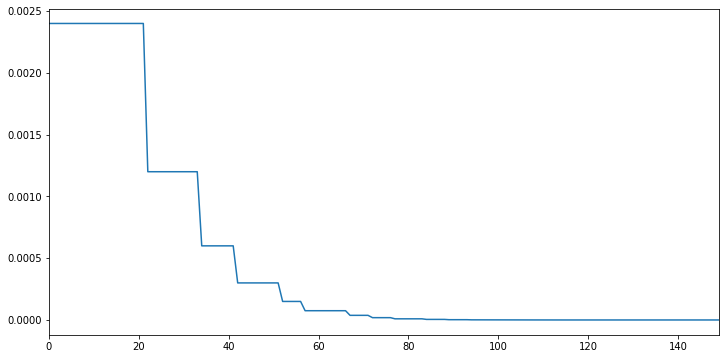

In [37]:
log['lr'].plot(figsize=(12,6));

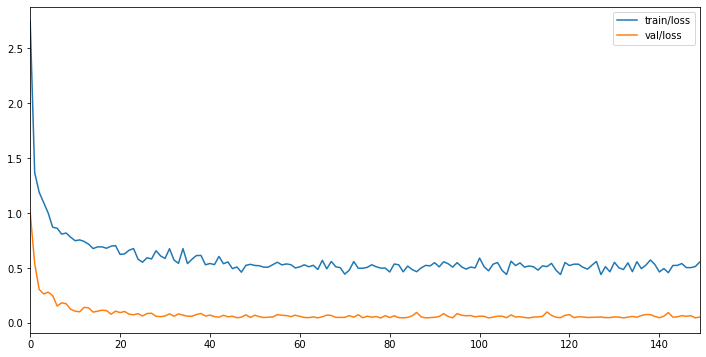

In [38]:
log[['train/loss','val/loss']].plot(figsize=(12,6));

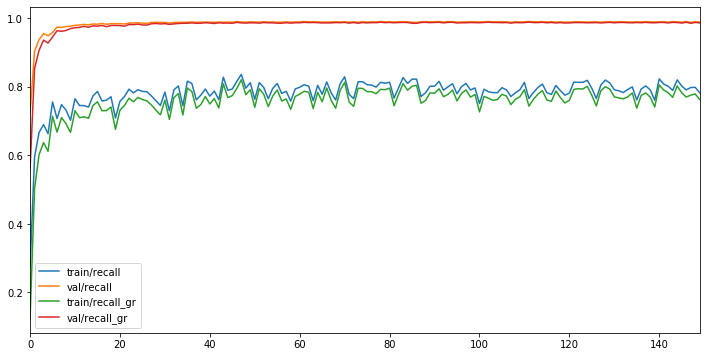

In [39]:
log[['train/recall','val/recall','train/recall_gr','val/recall_gr']].plot(figsize=(12,6));